In [1]:
import sys
import random
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms


In [2]:
sys.path.append(r"C:\Users\amrul\programming\deep_learning\dl_projects\Generative_Deep_Learning_2nd_Edition")

In [3]:
from notebooks.utils import display

In [4]:
# define constants
IMAGE_SIZE=32
CHANNELS=1
STEP_SIZE=10
STEPS=60
NOISE=0.005
ALPHA=0.1
GRADIENT_CLIP=0.03
BATCH_SIZE=128
BUFFER_SIZE=8192
LEARNING_RATE = 1e-4
EPOCHS=60

# Prepare MNIST dataset

In [5]:
import pathlib
datapath=pathlib.Path(r"C:\Users\amrul\programming\deep_learning\dl_projects\Generative_Deep_Learning_2nd_Edition\data")

transform = transforms.Compose([transforms.Pad(2),transforms.ToTensor(),transforms.Normalize(mean=[0.5],std=[0.5])])

train_mnist = datasets.MNIST(str(datapath),train=True,download=True,transform=transform)
test_mnist = datasets.MNIST(str(datapath),train=False,download=True, transform=transform)

print(f"train mnist size : {len(train_mnist)}, test mnist size : {len(test_mnist)}")

train mnist size : 60000, test mnist size : 10000


picked up indices [39638, 41971, 18311, 3127, 31932, 39805, 5955, 41339, 38839, 5948]


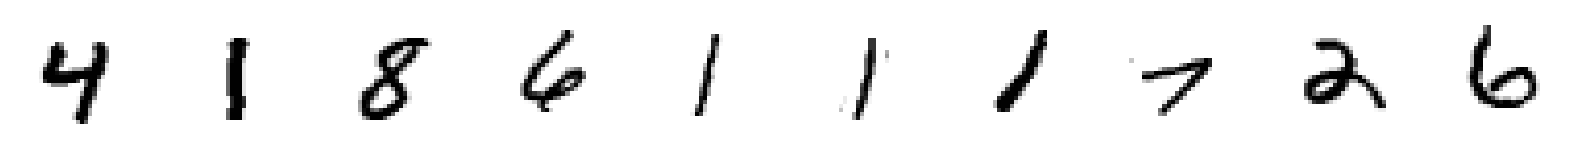

In [6]:
ten_random_indices = [random.choice(range(len(train_mnist)))for _ in range(10)]
print(f"picked up indices {ten_random_indices}")
ten_random_images = [train_mnist[idx][0] for idx in ten_random_indices]
random_images = torch.cat(ten_random_images,dim=0)
display(random_images.squeeze(1).numpy())

In [7]:
image=ten_random_images[0]
print(f"min val : {image.min()}, max val : {image.max()}")

min val : -1.0, max val : 1.0


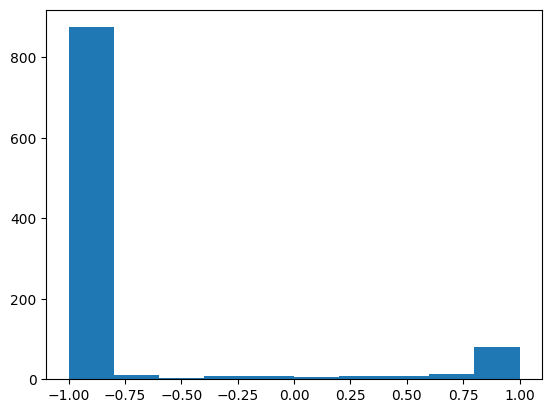

In [8]:
flat_image = image.flatten().numpy()
import matplotlib.pyplot as plt

plt.hist(flat_image)
plt.show()

In [9]:
from torch.utils.data import random_split

val_size = int(len(train_mnist)*0.2)
train_size = int(len(train_mnist)-val_size)
train_ds, val_ds = random_split(train_mnist,[train_size,val_size])
print(f"train_ds has {len(train_ds)}, val_ds has {len(val_ds)}")

train_ds has 48000, val_ds has 12000


In [10]:
# loaders
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_ds,batch_size=BATCH_SIZE)
test_loader = DataLoader(test_mnist,batch_size=BATCH_SIZE)

# Define the Langevin sampling, Energy function

In [11]:
def swish(x,beta=1.0):
    return x * F.sigmoid(beta*x)

In [12]:
class EnergyFunction(nn.Module):
    def __init__(self,out_size=2, out_channels=64) -> None:
        super(EnergyFunction,self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=1)
        self.conv2=nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.dense = nn.Linear(out_size*out_size*out_channels,64)
        self.dense2 = nn.Linear(64,1)
    
    def forward(self,x):
        x = swish(self.conv1(x))
        x = swish(self.conv2(x))
        x = swish(self.conv3(x))
        x = swish(self.conv4(x))
        x = x.flatten(start_dim=1)
        x = swish(self.dense(x))
        return self.dense2(x)


In [13]:
def generate_samples(model, inp_images, steps, step_size, noise, device, return_imgs_per_step=False):
    imgs_per_step = []     

    for _ in range(steps):
        inp_images = inp_images.detach()
        inp_images.requires_grad_(True)
        image_noises = torch.normal(0, noise, size = inp_images.size())
        image_noises = image_noises.to(device)
        noised_inp_images = inp_images + image_noises
        noised_inp_images = torch.clamp(noised_inp_images, -1.0, 1.0)               

        model.zero_grad()
        outscore = model(noised_inp_images)
        mean_outscore = torch.sum(outscore,dim=0)
        mean_outscore.backward()
        grads = torch.clamp(inp_images.grad,-1*GRADIENT_CLIP,GRADIENT_CLIP)
        inp_images = inp_images + step_size * grads
        inp_images = torch.clamp(inp_images, -1.0, 1.0)

        if return_imgs_per_step:
            imgs_per_step.append(inp_images)
    if return_imgs_per_step:
        return torch.stack(imgs_per_step,dim=0)
    return inp_images

In [14]:
class Buffer:
    def __init__(self,model, device) -> None:
        self.model=model
        self.device = device
        self.examples = [torch.rand(1,CHANNELS,IMAGE_SIZE,IMAGE_SIZE).to(self.device) for _ in range(BATCH_SIZE)]

    
    def sample_new_examples(self, steps, step_size, noise):
        # number of successes out of running an experiment with binomial outcomes BATCH_SIZE times with 5% probability of success rate
        n_new = np.random.binomial(BATCH_SIZE,0.05)
        
        # we are making values fall in -1.0 to 1.0 range
        rand_images = torch.rand(n_new, CHANNELS, IMAGE_SIZE, IMAGE_SIZE) * 2 -1
        rand_images = rand_images.to(self.device)
        
        # we are randomly choosing k examples and then concatenating them along batch dimension
        old_images = torch.cat(random.choices(self.examples, k=BATCH_SIZE-n_new), dim=0)        

        # concatenate newly randomly generated samples with picked up existing samples along batch dimension
        inp_images = torch.cat([old_images,rand_images], dim=0)
        inp_images = inp_images.to(self.device)

        # pass inp_images through langevin dynamics
        inp_images = generate_samples(self.model, inp_images, steps, step_size, noise, self.device)

        # append inp_images to the front of examples
        # pay attention to torch.split, in the second argument we are specifying what should be axis 0 size after splitting
        # which should equal 1 in this case
        self.examples = list(torch.split(inp_images, inp_images.size(0)//BATCH_SIZE, dim=0)) + self.examples

        # throw away examples that exceed buffer size
        self.examples = self.examples[:BUFFER_SIZE]

        return inp_images

In [15]:
def image_generator(model,buffer,num_img,epoch,device):
    start_imgs = torch.rand(num_img, CHANNELS, IMAGE_SIZE, IMAGE_SIZE) * 2 - 1
    start_imgs = start_imgs.to(device)
    generated_images = generate_samples(
        model,
        start_imgs,
        steps=1000,
        step_size=STEP_SIZE,
        noise=NOISE,
        device=device
        
    )
    generated_images = generated_images.detach().squeeze(1).cpu().numpy()
    display(
        generated_images,
        save_to="./output/generated_img_%03d.png" % (epoch),
    )

    example_images = torch.cat(
        random.choices(buffer.examples, k=10), dim=0
    )
    example_images = example_images.detach().squeeze(1).cpu().numpy()
    display(
        example_images, save_to="./output/example_img_%03d.png" % (epoch)
    )

# Define Training Loop

In [16]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"device is {device}")

device is cuda


In [17]:
def loss_fn(real_out, fake_out):
    cdiv_loss = torch.mean(fake_out, dim=0) - torch.mean(real_out, dim=0)
    reg_loss = ALPHA * torch.mean(real_out**2+fake_out**2, dim=0)
    loss = cdiv_loss + reg_loss
    return loss, cdiv_loss, reg_loss

In [18]:
def compute_val_loss(model, val_loader, buffer):
    val_loss = 0
    for images,labels in val_loader:
        images = images.to(device)
        fake_images = buffer.sample_new_examples(STEPS, STEP_SIZE, NOISE)
        inp_images = torch
        inp_images = torch.cat([images,fake_images], dim=0)
        with torch.no_grad():
            out = model(inp_images)

            real_out, fake_out = torch.split(out, out.size(0)//2)
            loss, cdiv_loss, reg_loss = loss_fn(real_out, fake_out)

        val_loss += loss.item()
    return val_loss/len(val_loader)

In [19]:
models_folder = pathlib.Path(r"C:\Users\amrul\programming\deep_learning\dl_projects\Generative_Deep_Learning_2nd_Edition\notebooks\07_ebm\01_ebm\models")

def training_loop(n_epochs, optimizer, model, buffer, loss_fn, train_loader, val_loader):
    best_val_loss = float("inf")
    train_losses = []
    val_losses = []
    reg_losses = []
    cdiv_losses = []
    real_outs = []
    fake_outs = []

    for epoch in tqdm(range(1, n_epochs+1), position=0, desc="Epoch Loop"):
        loss_train = 0

        for images, labels in tqdm(train_loader, position=0, desc=f"Epoch {epoch} Iteration Loop"):
            images = images.to(device)
            image_noises = torch.normal(mean=0, std=NOISE, size=images.size())
            image_noises = image_noises.to(device)
            noised_images = images + image_noises
            noised_images = torch.clamp(images, -1.0, 1.0)

            fake_images = buffer.sample_new_examples(STEPS, STEP_SIZE, NOISE)
            inp_images = torch.cat([noised_images,fake_images], dim=0)
            out = model(inp_images)

            real_out, fake_out = torch.split(out, out.size(0)//2)
            loss, cdiv_loss, reg_loss = loss_fn(real_out, fake_out)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            cdiv_losses.append(cdiv_loss.item())
            reg_losses.append(reg_loss.item())
            train_losses.append(loss.item())
            real_outs.append(real_out)
            fake_outs.append(fake_out)

            loss_train += loss.item()
        
        avg_loss_train = loss_train / len(train_loader)
        print(f"Epoch {epoch} train loss : {avg_loss_train}")

        
        val_loss = compute_val_loss(model,val_loader,buffer)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss

            print(f"Saving epoch {epoch} weights with val loss {val_loss}")
            torch.save(model.state_dict(),str(models_folder/"ebm_pytorch_weights.pt"))
        image_generator(model,buffer,10,epoch,device)
    return train_losses,val_losses,cdiv_losses, reg_losses, real_outs, fake_outs


In [20]:
model = EnergyFunction(out_size=2, out_channels=64)

In [21]:
model = model.to(device)

In [22]:
buffer = Buffer(model,device)

Epoch 1 Iteration Loop: 100%|██████████| 375/375 [01:16<00:00,  4.88it/s]


Epoch 1 train loss : -0.05292735816235654
Saving epoch 1 weights with val loss -0.01623633455366213

Saved to ./output/generated_img_001.png


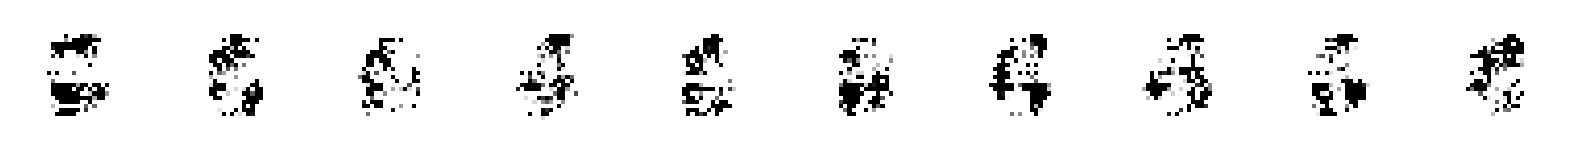


Saved to ./output/example_img_001.png


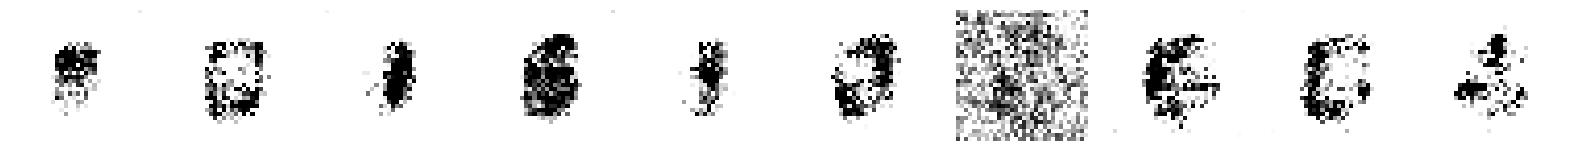

Epoch 2 Iteration Loop: 100%|██████████| 375/375 [01:04<00:00,  5.85it/s]


Epoch 2 train loss : -0.011988991219860813

Saved to ./output/generated_img_002.png


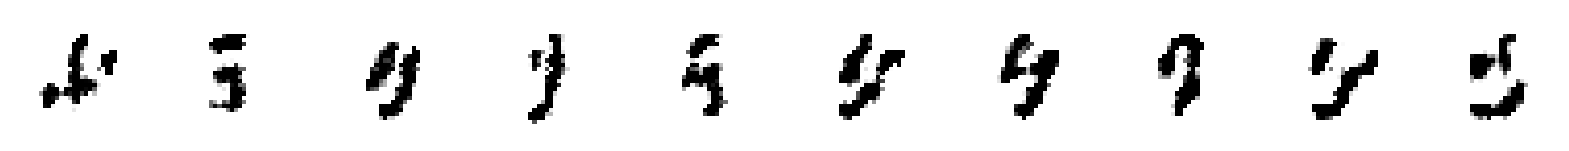


Saved to ./output/example_img_002.png


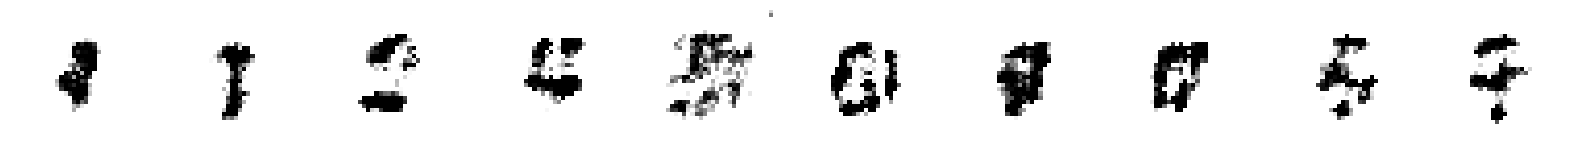

Epoch 3 Iteration Loop: 100%|██████████| 375/375 [00:57<00:00,  6.56it/s]


Epoch 3 train loss : -0.0032527781397414706

Saved to ./output/generated_img_003.png


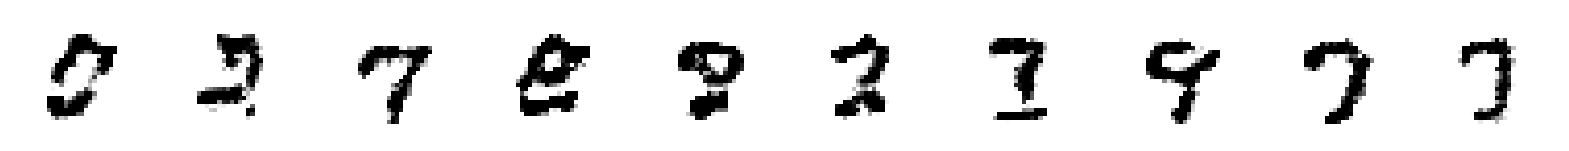


Saved to ./output/example_img_003.png


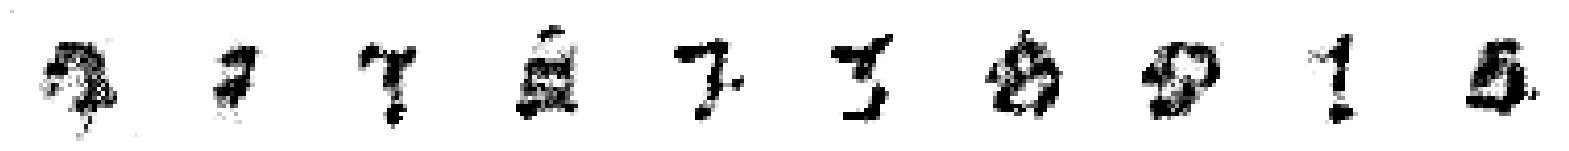

Epoch 4 Iteration Loop: 100%|██████████| 375/375 [00:59<00:00,  6.33it/s]


Epoch 4 train loss : -0.0008573309956118464

Saved to ./output/generated_img_004.png


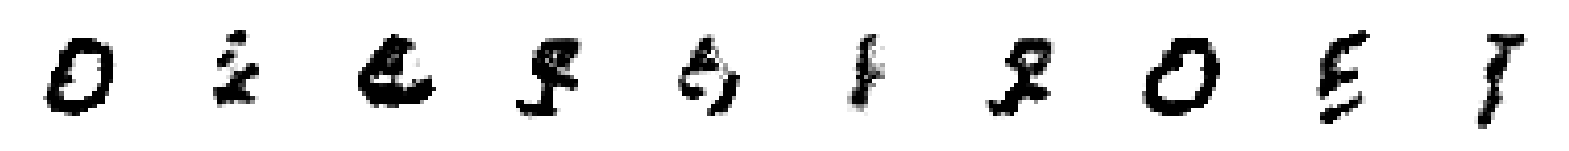


Saved to ./output/example_img_004.png


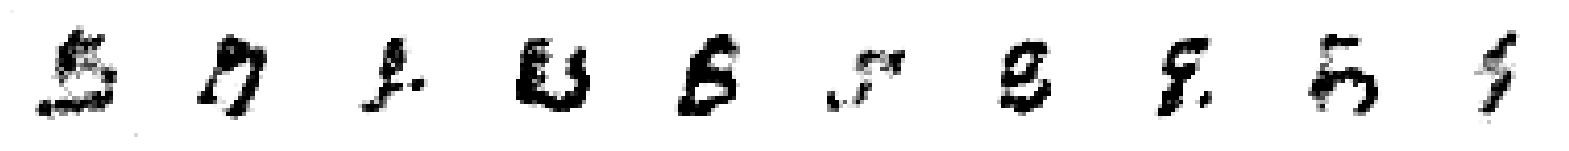

Epoch 5 Iteration Loop: 100%|██████████| 375/375 [00:53<00:00,  7.01it/s]


Epoch 5 train loss : -0.0007678298596680785

Saved to ./output/generated_img_005.png


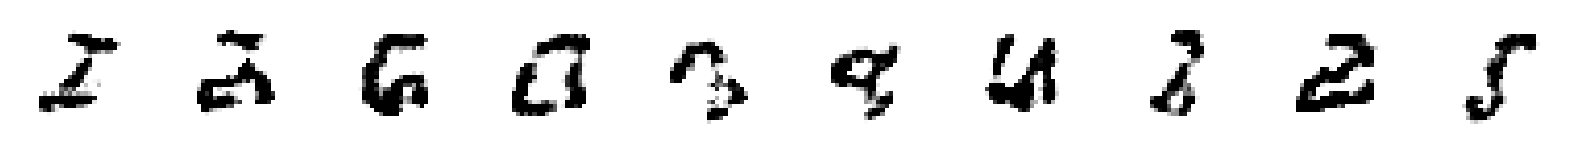


Saved to ./output/example_img_005.png


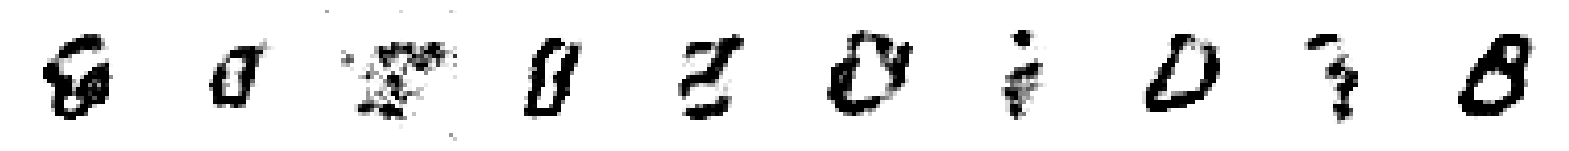

Epoch 6 Iteration Loop: 100%|██████████| 375/375 [01:06<00:00,  5.65it/s]


Epoch 6 train loss : -0.0005815428103863572

Saved to ./output/generated_img_006.png


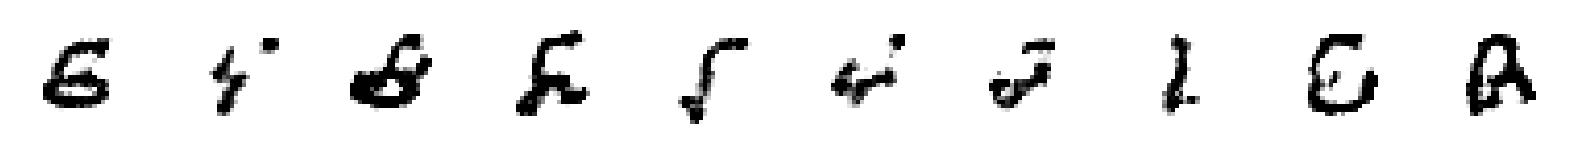


Saved to ./output/example_img_006.png


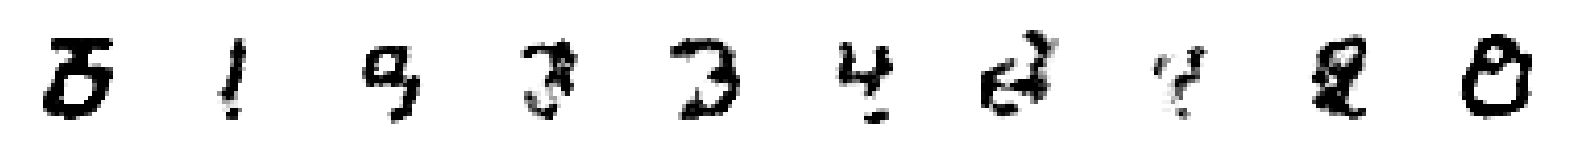

Epoch 7 Iteration Loop: 100%|██████████| 375/375 [01:00<00:00,  6.23it/s]


Epoch 7 train loss : -0.00093140363584583

Saved to ./output/generated_img_007.png


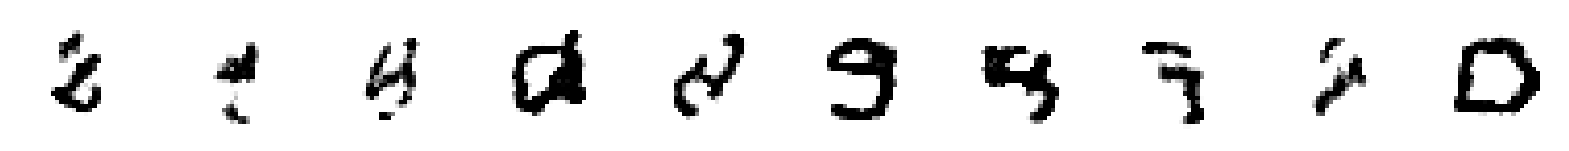


Saved to ./output/example_img_007.png


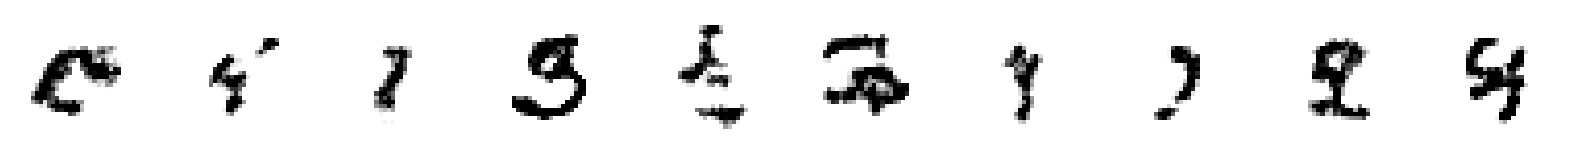

Epoch 8 Iteration Loop: 100%|██████████| 375/375 [00:53<00:00,  6.97it/s]


Epoch 8 train loss : -1.7799755092710255e-05

Saved to ./output/generated_img_008.png


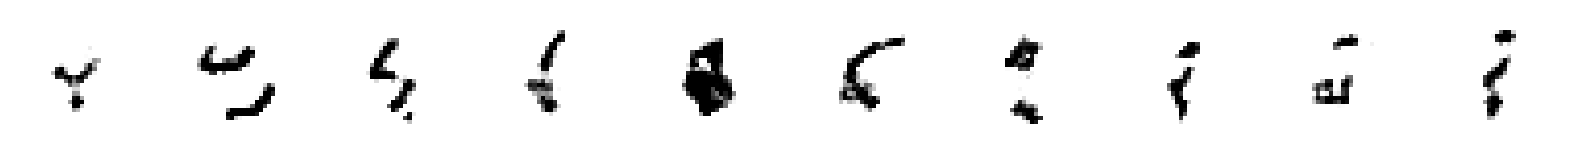


Saved to ./output/example_img_008.png


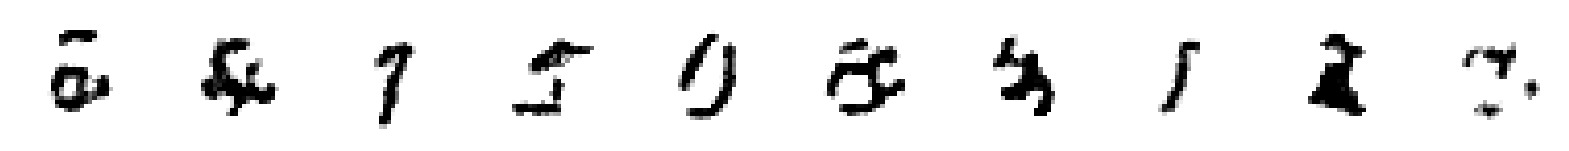

Epoch 9 Iteration Loop: 100%|██████████| 375/375 [01:01<00:00,  6.13it/s]


Epoch 9 train loss : -0.0004479470265408357

Saved to ./output/generated_img_009.png


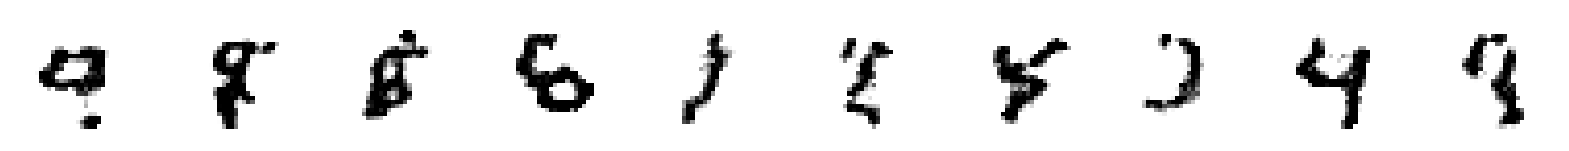


Saved to ./output/example_img_009.png


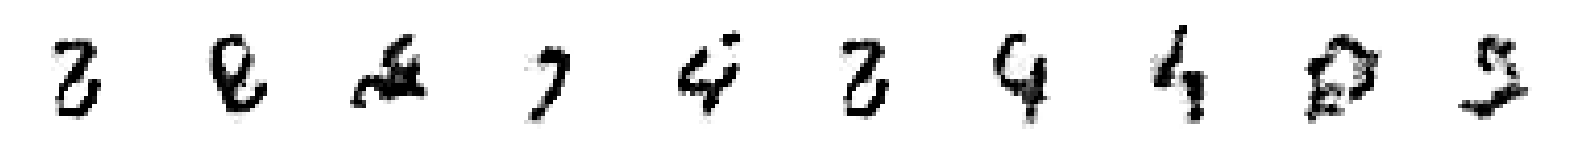

Epoch 10 Iteration Loop: 100%|██████████| 375/375 [00:55<00:00,  6.77it/s]


Epoch 10 train loss : -0.0005554428260074928

Saved to ./output/generated_img_010.png


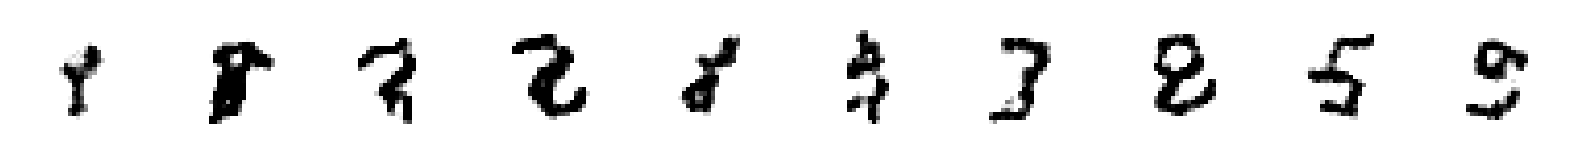


Saved to ./output/example_img_010.png


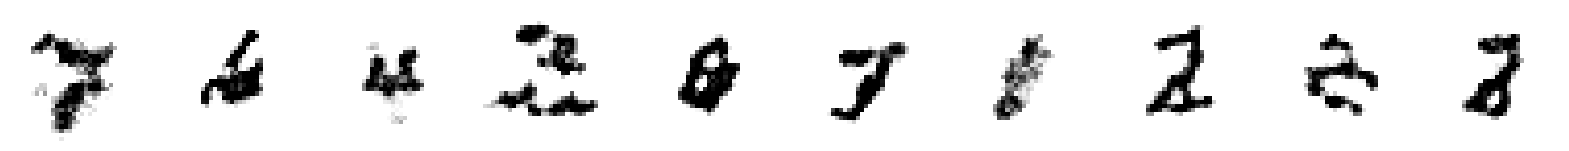

Epoch 11 Iteration Loop: 100%|██████████| 375/375 [01:06<00:00,  5.68it/s]


Epoch 11 train loss : -0.000365392611711286

Saved to ./output/generated_img_011.png


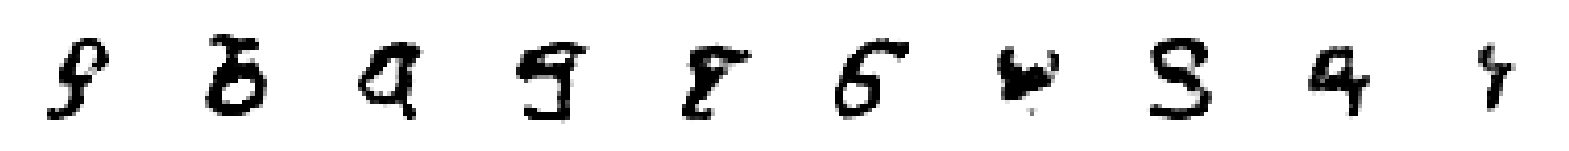


Saved to ./output/example_img_011.png


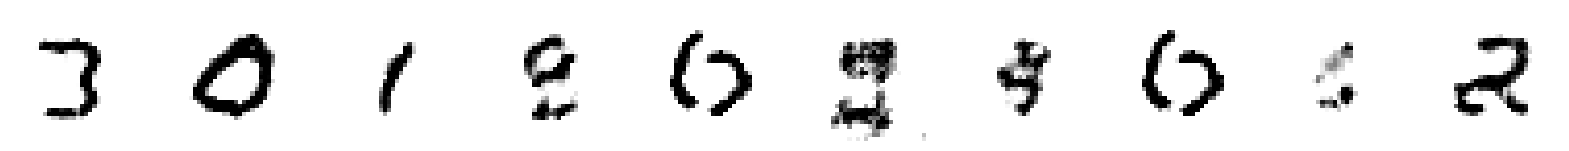

Epoch 12 Iteration Loop: 100%|██████████| 375/375 [01:01<00:00,  6.09it/s]


Epoch 12 train loss : -0.0002628624038285731

Saved to ./output/generated_img_012.png


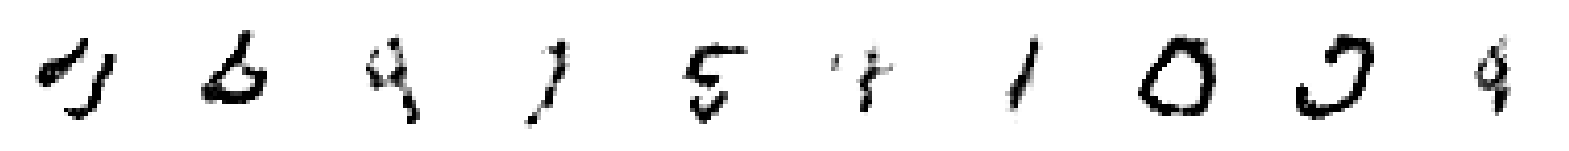


Saved to ./output/example_img_012.png


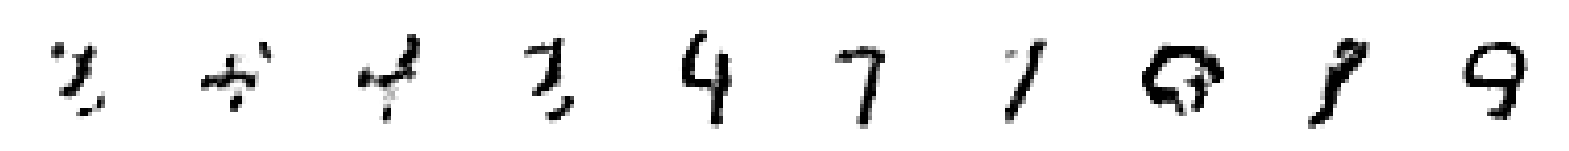

Epoch 13 Iteration Loop: 100%|██████████| 375/375 [01:03<00:00,  5.94it/s]


Epoch 13 train loss : -0.0004516079108580016

Saved to ./output/generated_img_013.png


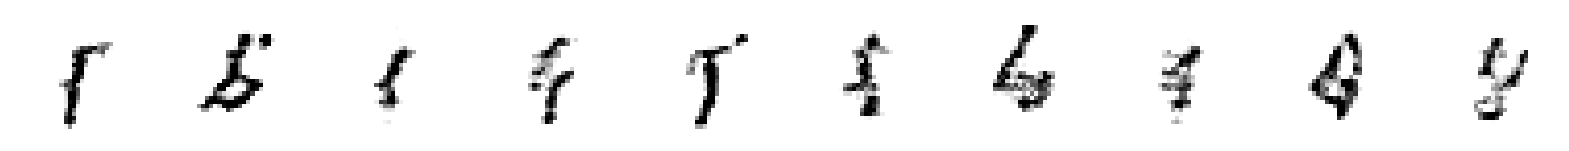


Saved to ./output/example_img_013.png


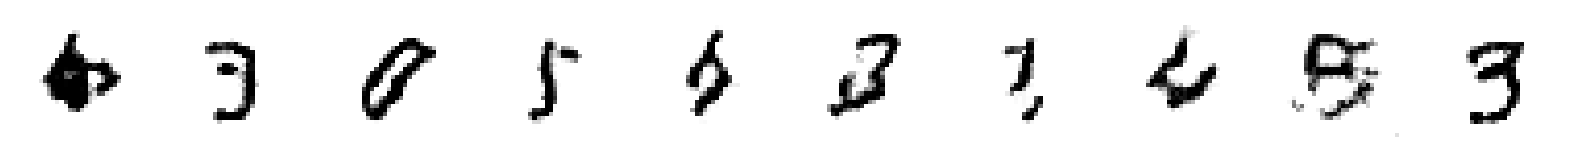

Epoch 14 Iteration Loop: 100%|██████████| 375/375 [00:57<00:00,  6.47it/s]


Epoch 14 train loss : -0.0005618440248072147

Saved to ./output/generated_img_014.png


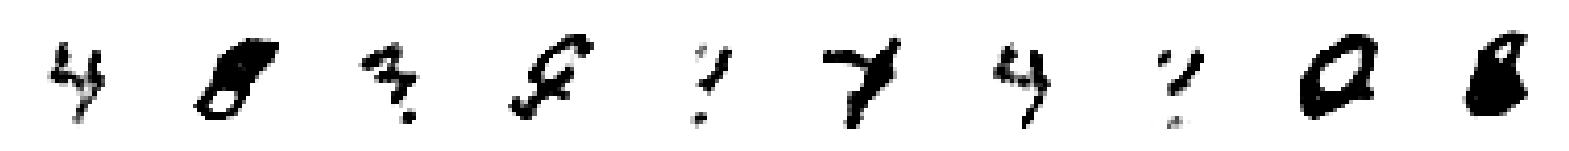


Saved to ./output/example_img_014.png


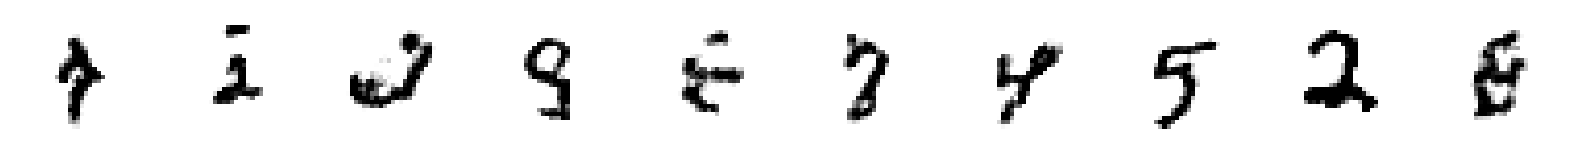

Epoch 15 Iteration Loop: 100%|██████████| 375/375 [01:02<00:00,  5.99it/s]


Epoch 15 train loss : -0.00011076446750666946

Saved to ./output/generated_img_015.png


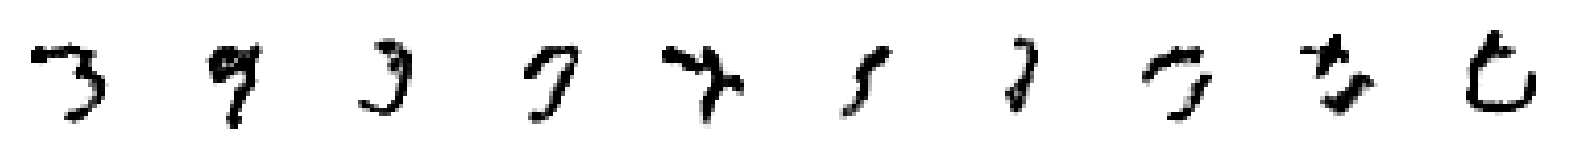


Saved to ./output/example_img_015.png


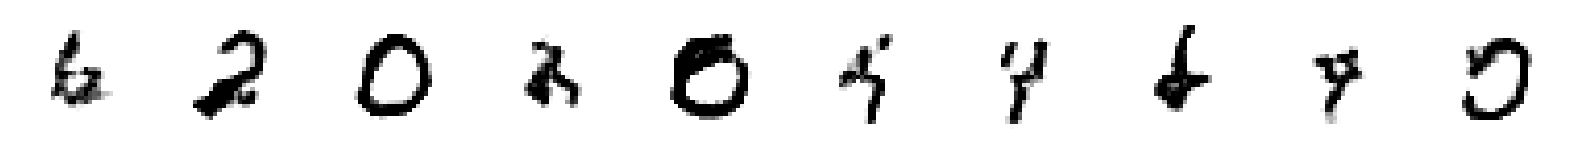

Epoch 16 Iteration Loop: 100%|██████████| 375/375 [01:06<00:00,  5.61it/s]


Epoch 16 train loss : -0.00018142150053366396

Saved to ./output/generated_img_016.png


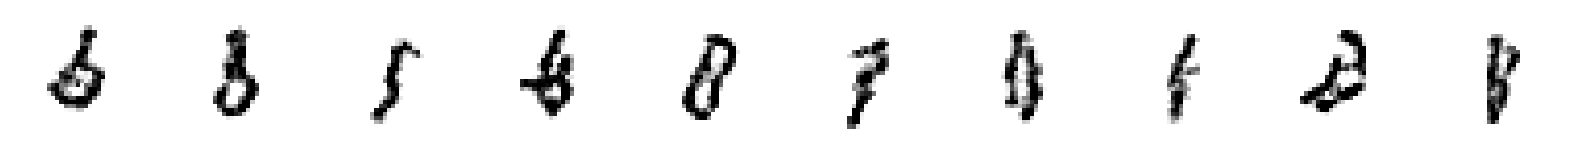


Saved to ./output/example_img_016.png


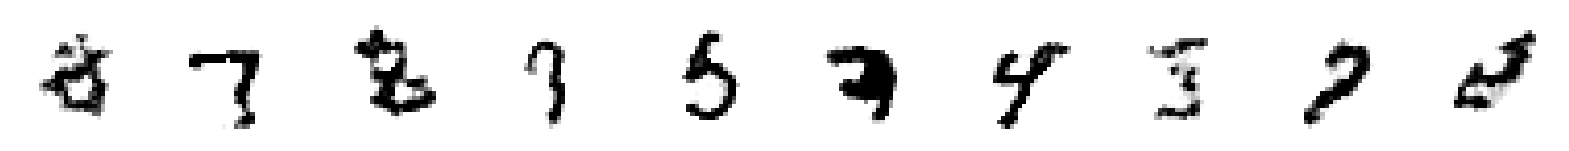

Epoch 17 Iteration Loop: 100%|██████████| 375/375 [00:53<00:00,  6.98it/s]


Epoch 17 train loss : -0.0003625135777401738

Saved to ./output/generated_img_017.png


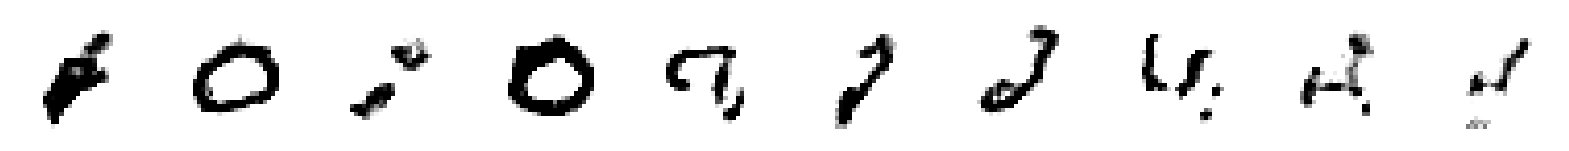


Saved to ./output/example_img_017.png


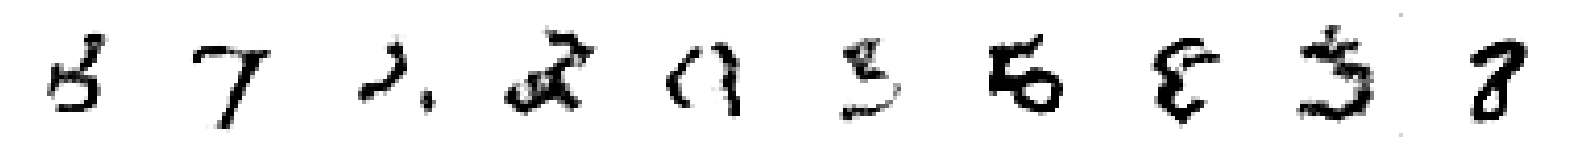

Epoch 18 Iteration Loop: 100%|██████████| 375/375 [00:57<00:00,  6.49it/s]


Epoch 18 train loss : -0.00019332662565284408

Saved to ./output/generated_img_018.png


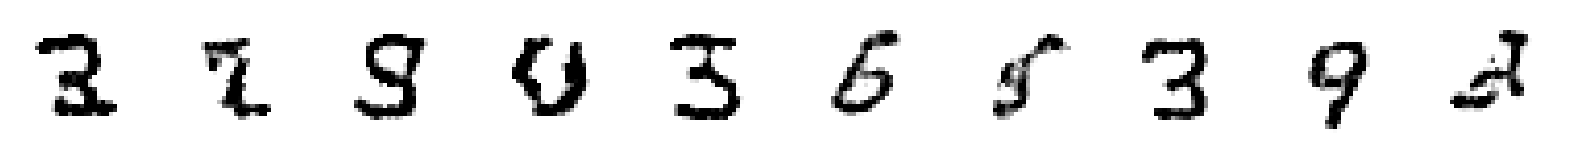


Saved to ./output/example_img_018.png


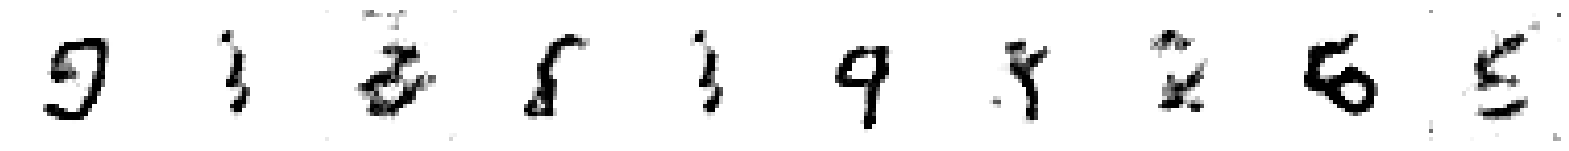

Epoch 19 Iteration Loop: 100%|██████████| 375/375 [00:54<00:00,  6.85it/s]


Epoch 19 train loss : -0.00024539746097677076

Saved to ./output/generated_img_019.png


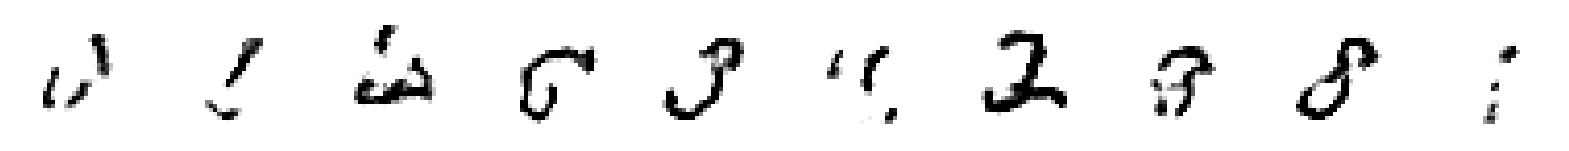


Saved to ./output/example_img_019.png


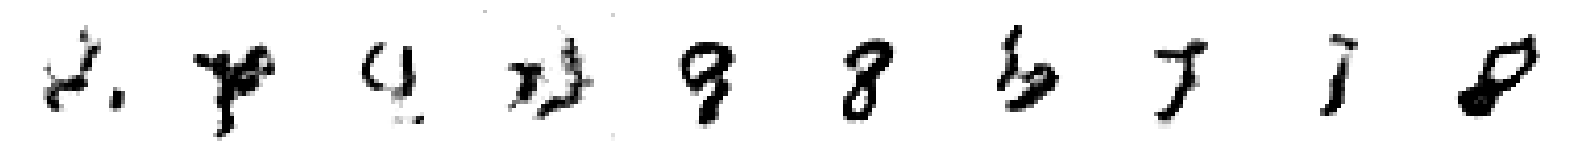

Epoch 20 Iteration Loop: 100%|██████████| 375/375 [01:06<00:00,  5.64it/s]


Epoch 20 train loss : -0.00015601136508242537

Saved to ./output/generated_img_020.png


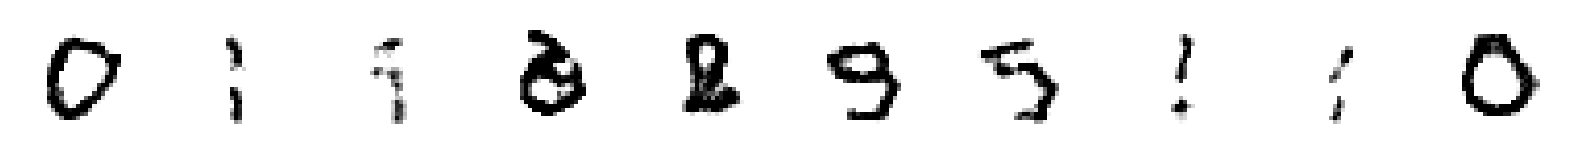


Saved to ./output/example_img_020.png


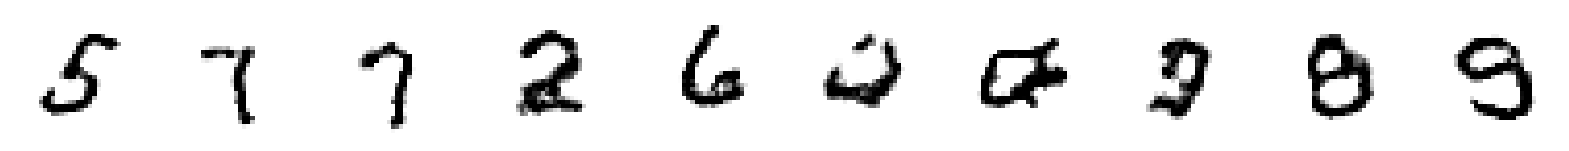

Epoch 21 Iteration Loop: 100%|██████████| 375/375 [01:03<00:00,  5.87it/s]


Epoch 21 train loss : -0.0001345175643218681

Saved to ./output/generated_img_021.png


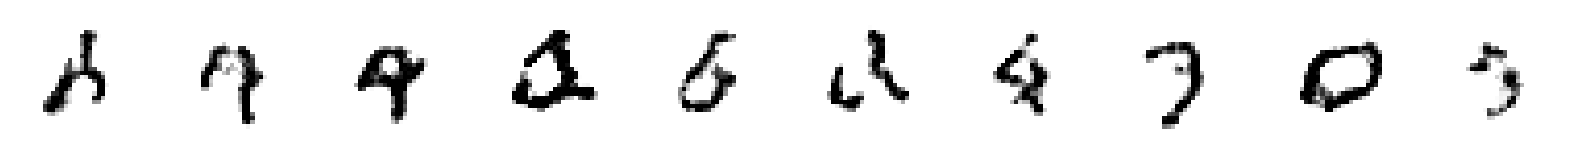


Saved to ./output/example_img_021.png


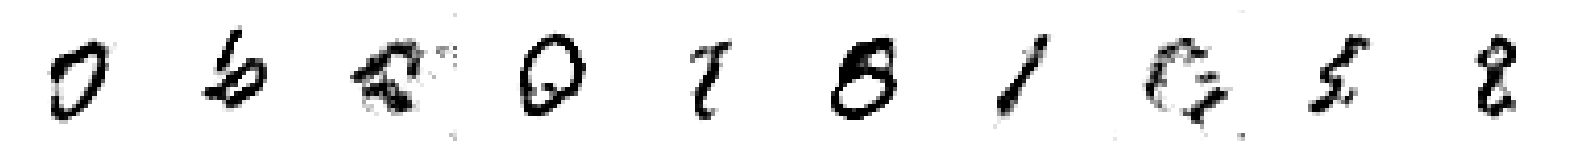

Epoch 22 Iteration Loop: 100%|██████████| 375/375 [00:55<00:00,  6.73it/s]


Epoch 22 train loss : -0.0002134791708861788

Saved to ./output/generated_img_022.png


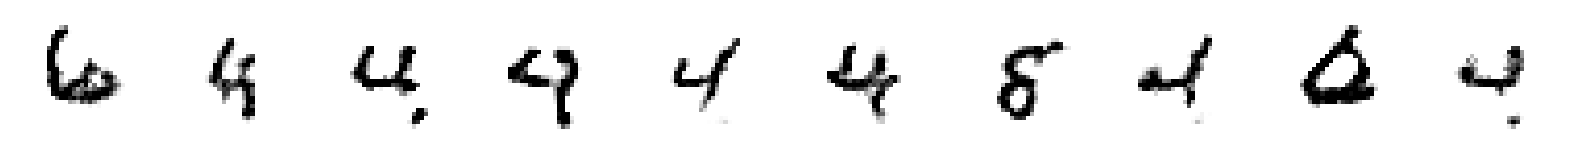


Saved to ./output/example_img_022.png


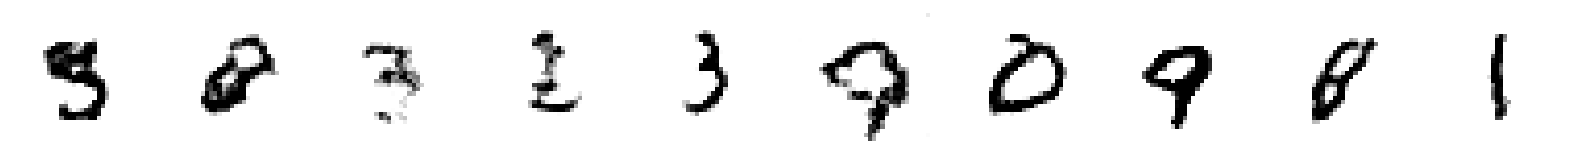

Epoch 23 Iteration Loop: 100%|██████████| 375/375 [00:59<00:00,  6.32it/s]


Epoch 23 train loss : -0.00037782463507028295

Saved to ./output/generated_img_023.png


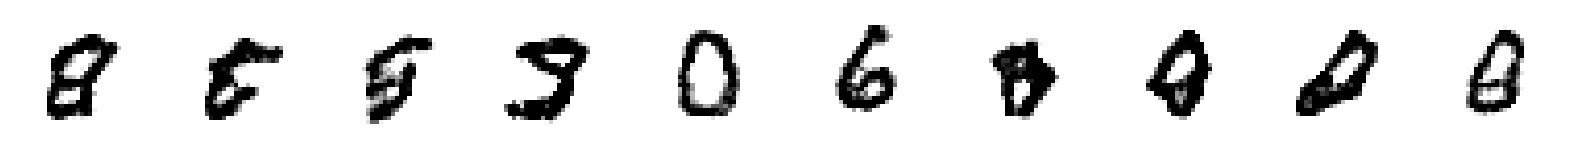


Saved to ./output/example_img_023.png


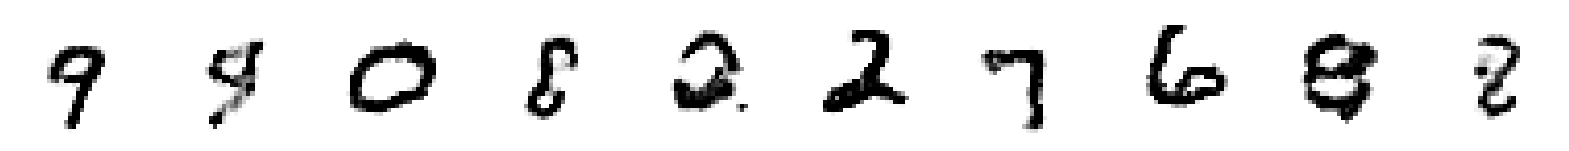

Epoch 24 Iteration Loop: 100%|██████████| 375/375 [00:55<00:00,  6.72it/s]


Epoch 24 train loss : -0.00013692263057843473

Saved to ./output/generated_img_024.png


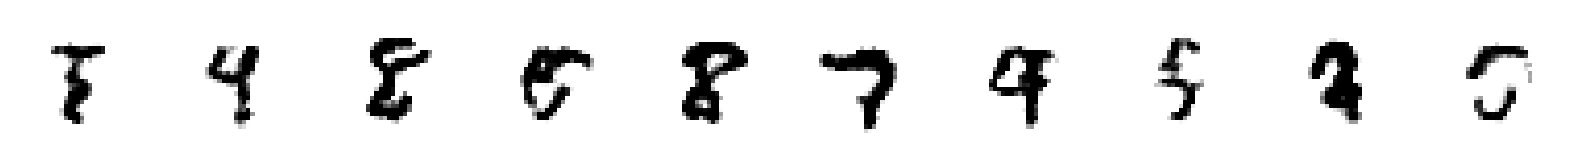


Saved to ./output/example_img_024.png


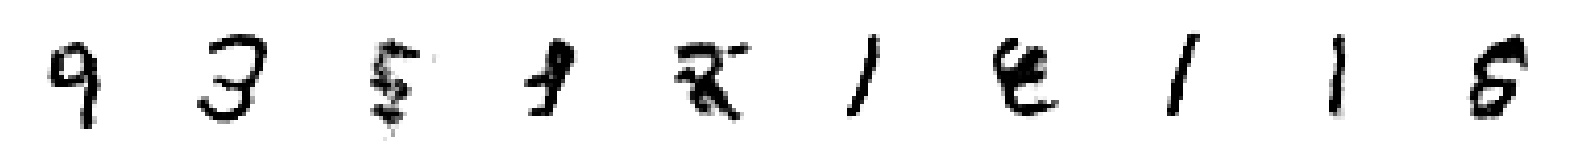

Epoch 25 Iteration Loop: 100%|██████████| 375/375 [01:07<00:00,  5.55it/s]


Epoch 25 train loss : -0.00033005037372155736

Saved to ./output/generated_img_025.png


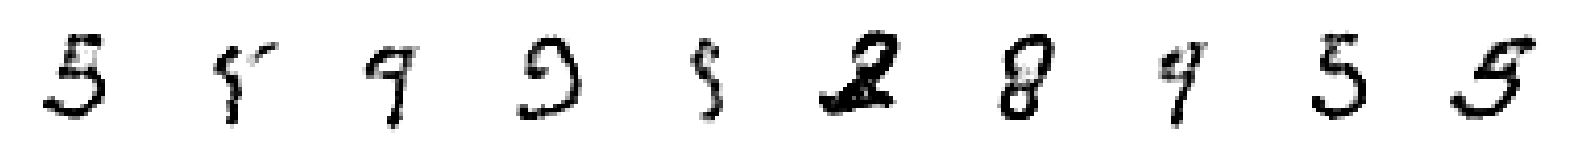


Saved to ./output/example_img_025.png


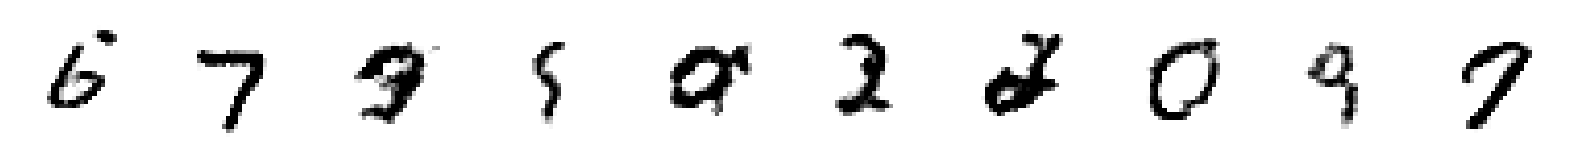

Epoch 26 Iteration Loop: 100%|██████████| 375/375 [01:00<00:00,  6.24it/s]


Epoch 26 train loss : -5.242585910794636e-05

Saved to ./output/generated_img_026.png


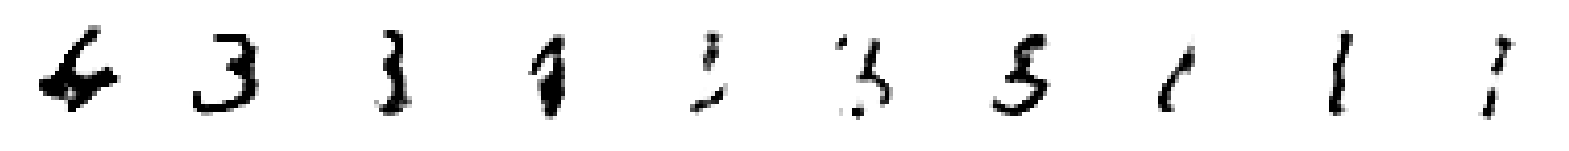


Saved to ./output/example_img_026.png


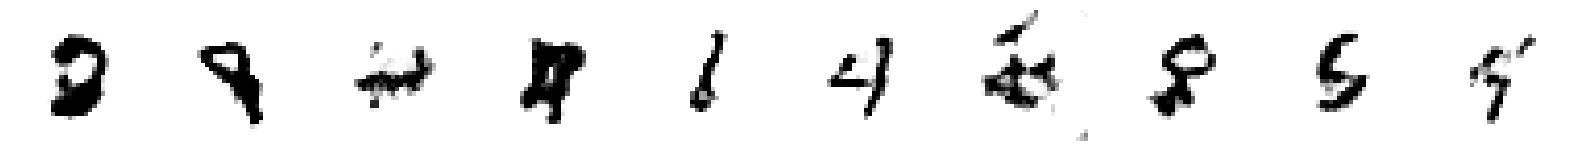

Epoch 27 Iteration Loop: 100%|██████████| 375/375 [02:18<00:00,  2.70it/s]


Epoch 27 train loss : -0.00010624309109213452

Saved to ./output/generated_img_027.png


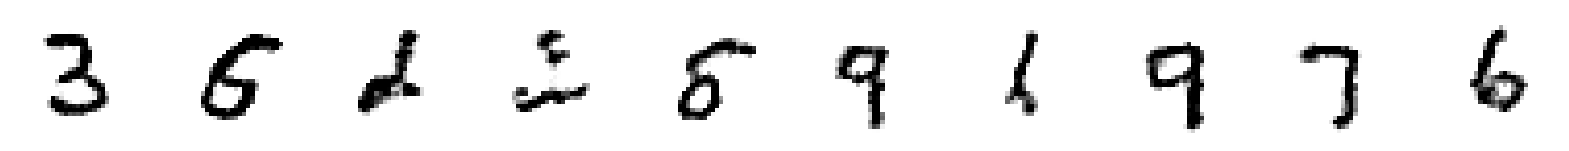


Saved to ./output/example_img_027.png


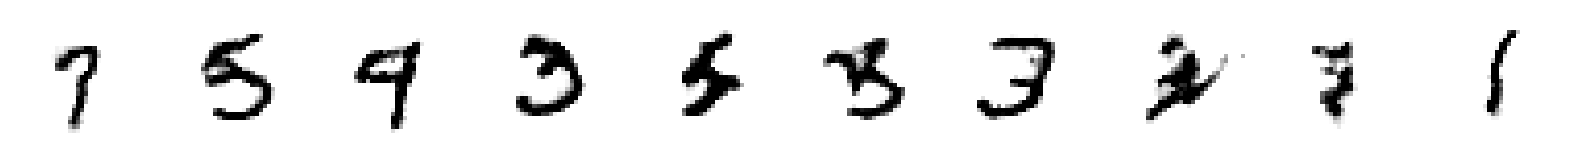

Epoch 28 Iteration Loop: 100%|██████████| 375/375 [02:29<00:00,  2.51it/s]


Epoch 28 train loss : -0.00026784797521152843

Saved to ./output/generated_img_028.png


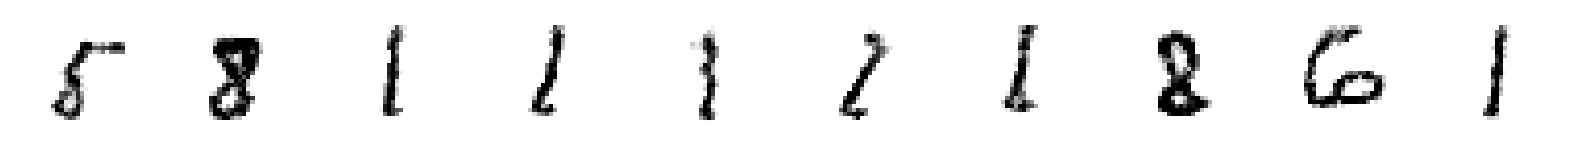


Saved to ./output/example_img_028.png


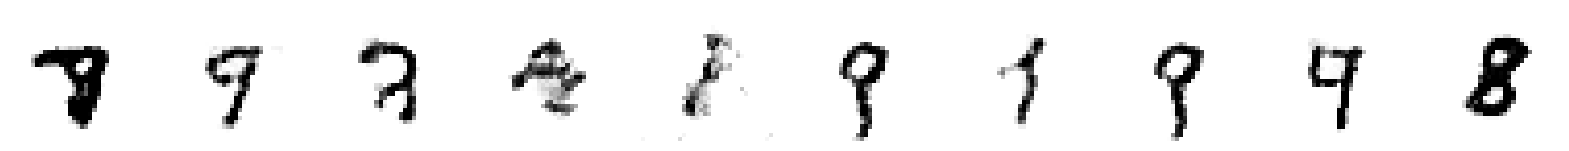

Epoch 29 Iteration Loop: 100%|██████████| 375/375 [02:20<00:00,  2.67it/s]


Epoch 29 train loss : -0.00028947608875265967

Saved to ./output/generated_img_029.png


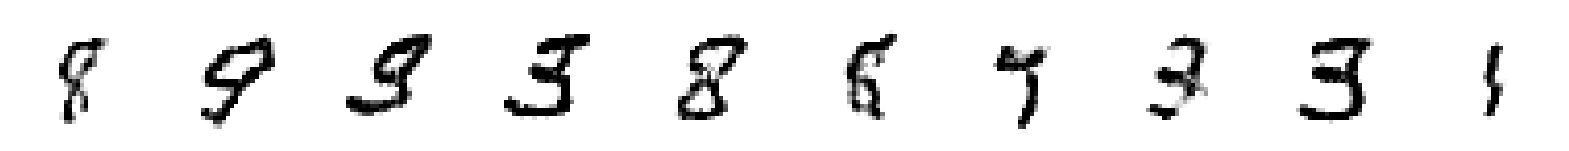


Saved to ./output/example_img_029.png


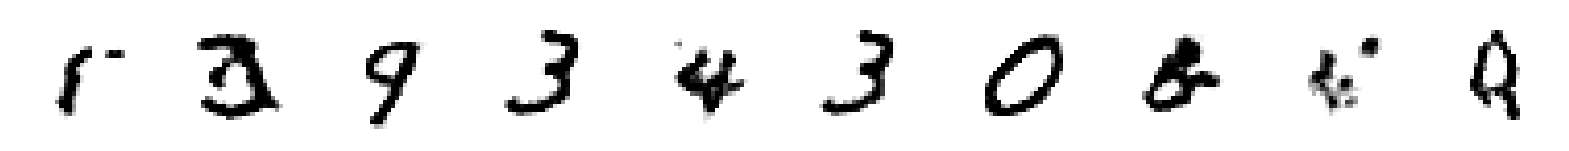

Epoch 30 Iteration Loop: 100%|██████████| 375/375 [02:22<00:00,  2.64it/s]


Epoch 30 train loss : -0.00018353502343719204

Saved to ./output/generated_img_030.png


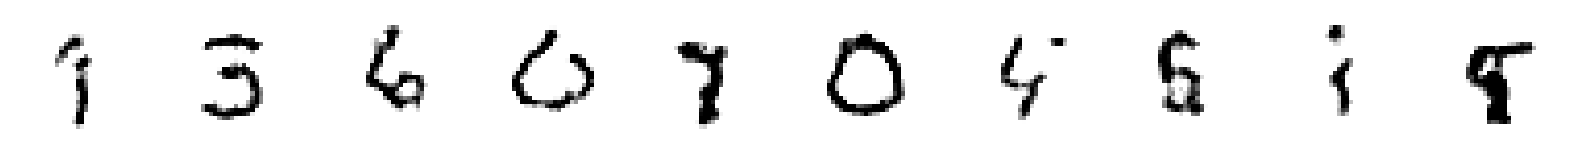


Saved to ./output/example_img_030.png


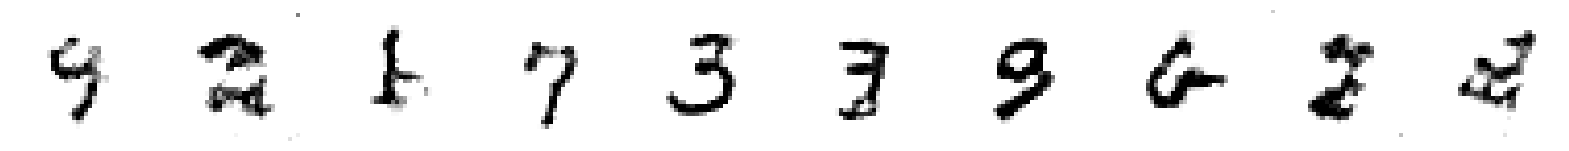

Epoch 31 Iteration Loop: 100%|██████████| 375/375 [02:35<00:00,  2.41it/s]


Epoch 31 train loss : -0.00031715229211840777

Saved to ./output/generated_img_031.png


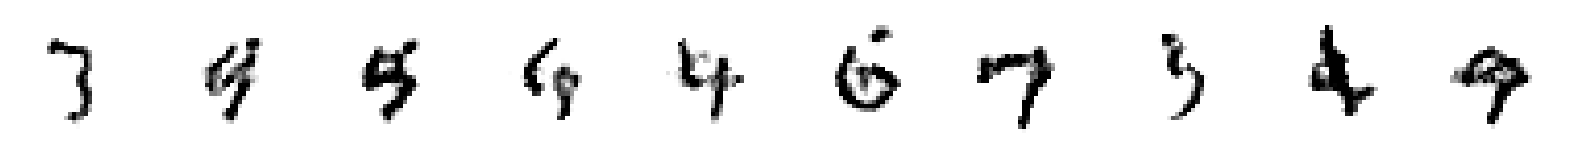


Saved to ./output/example_img_031.png


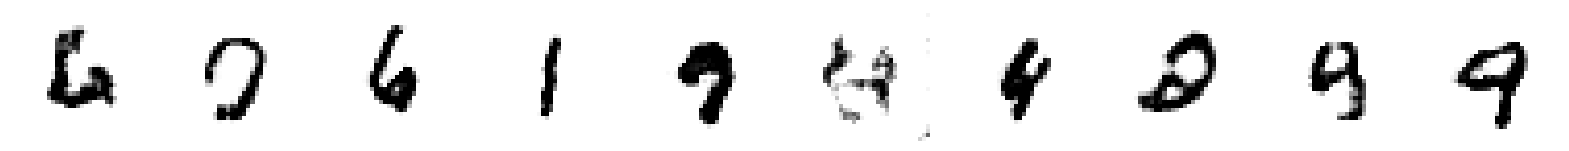

Epoch 32 Iteration Loop: 100%|██████████| 375/375 [02:33<00:00,  2.44it/s]


Epoch 32 train loss : -0.00031943911201475807

Saved to ./output/generated_img_032.png


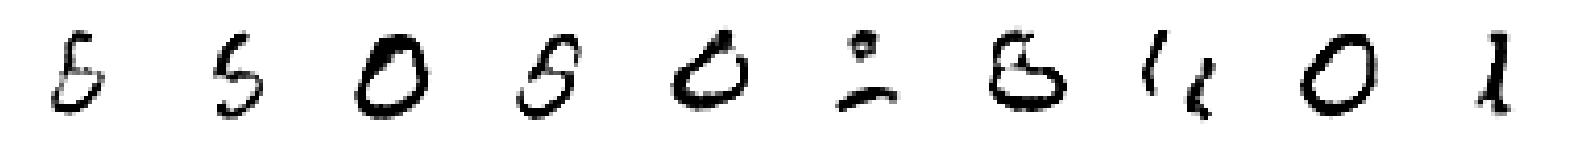


Saved to ./output/example_img_032.png


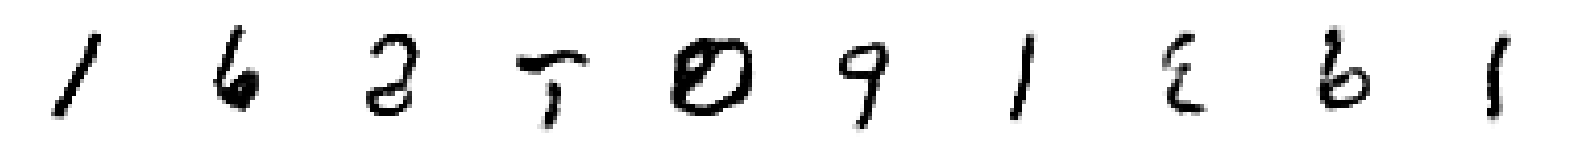

Epoch 33 Iteration Loop: 100%|██████████| 375/375 [02:33<00:00,  2.44it/s]


Epoch 33 train loss : -0.00010850948573594603

Saved to ./output/generated_img_033.png


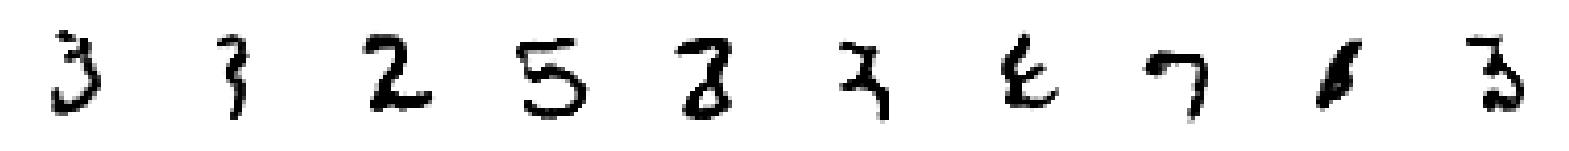


Saved to ./output/example_img_033.png


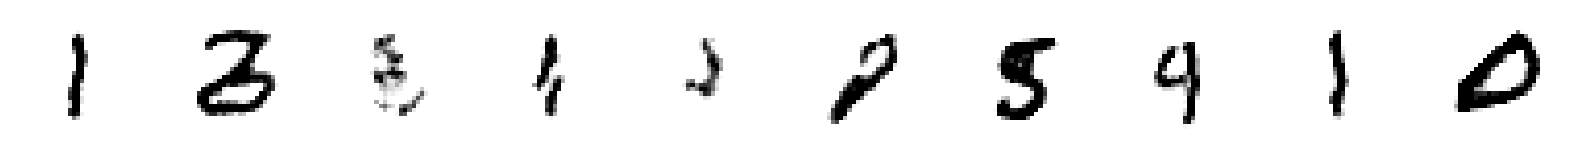

Epoch 34 Iteration Loop: 100%|██████████| 375/375 [02:34<00:00,  2.42it/s]


Epoch 34 train loss : -0.0004899638445349411

Saved to ./output/generated_img_034.png


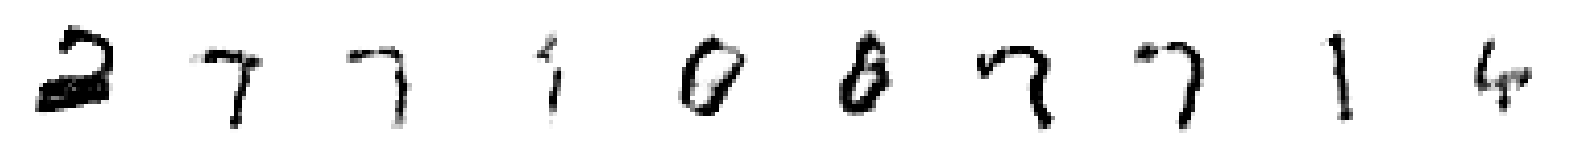


Saved to ./output/example_img_034.png


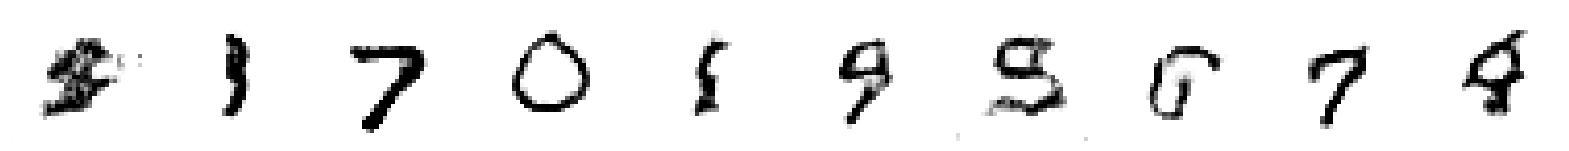

Epoch 35 Iteration Loop: 100%|██████████| 375/375 [02:31<00:00,  2.48it/s]


Epoch 35 train loss : -0.0002504953215830028

Saved to ./output/generated_img_035.png


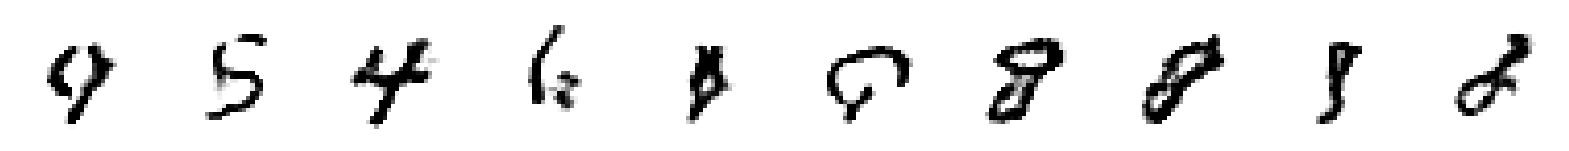


Saved to ./output/example_img_035.png


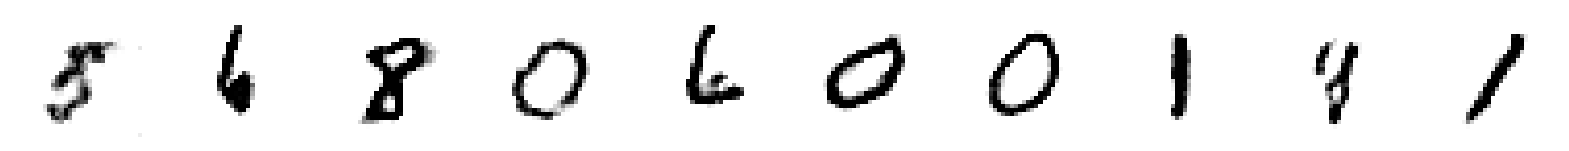

Epoch 36 Iteration Loop: 100%|██████████| 375/375 [02:33<00:00,  2.44it/s]


Epoch 36 train loss : -0.00032418260707830387

Saved to ./output/generated_img_036.png


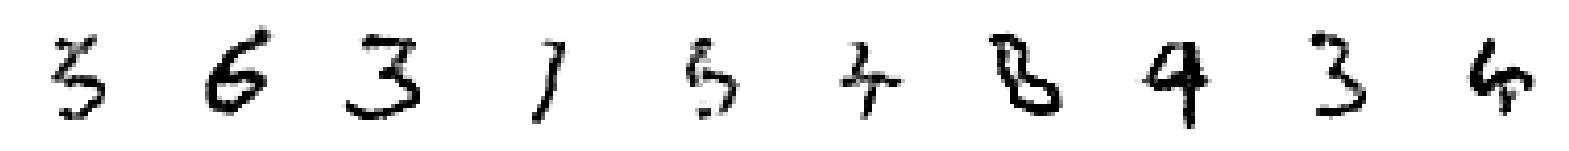


Saved to ./output/example_img_036.png


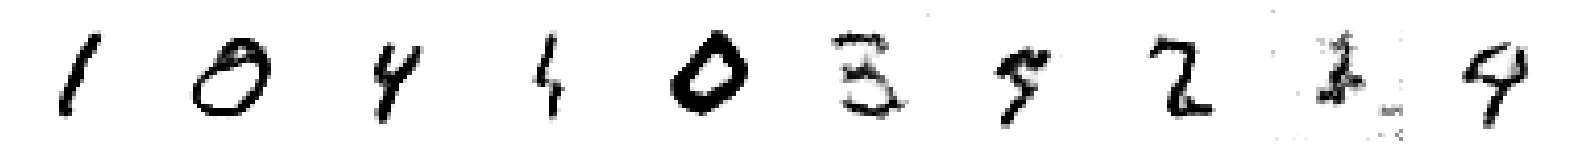

Epoch 37 Iteration Loop: 100%|██████████| 375/375 [02:54<00:00,  2.14it/s]


Epoch 37 train loss : -0.00012696400453569368

Saved to ./output/generated_img_037.png


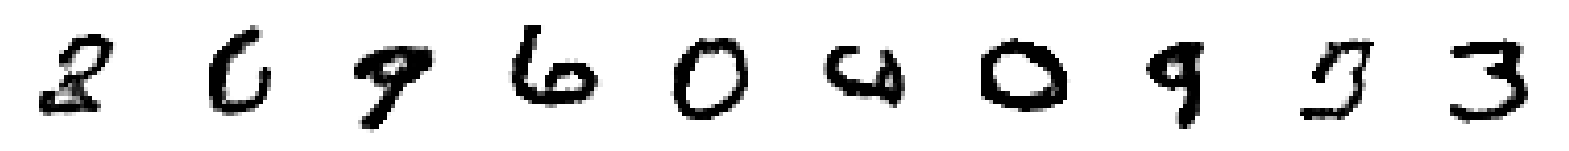


Saved to ./output/example_img_037.png


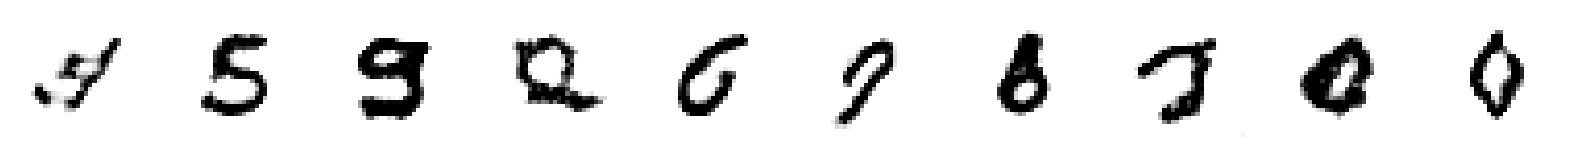

Epoch 38 Iteration Loop: 100%|██████████| 375/375 [03:00<00:00,  2.08it/s]


Epoch 38 train loss : -0.0002965374436656324

Saved to ./output/generated_img_038.png


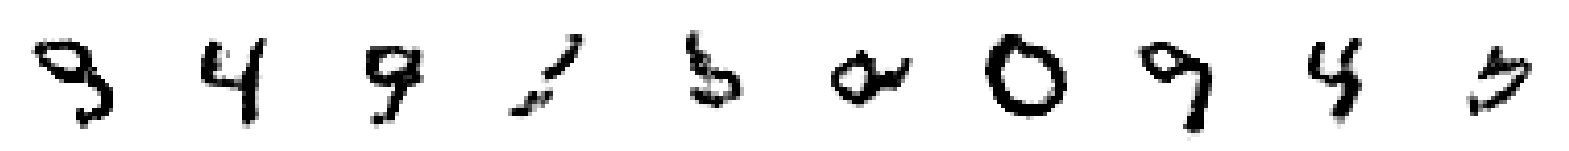


Saved to ./output/example_img_038.png


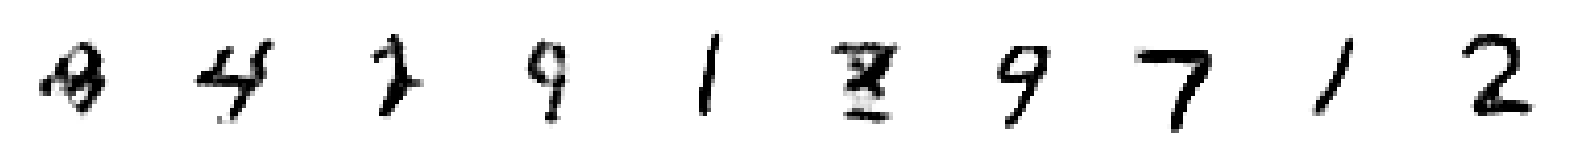

Epoch 39 Iteration Loop: 100%|██████████| 375/375 [03:03<00:00,  2.05it/s]


Epoch 39 train loss : -0.00017932674121887734

Saved to ./output/generated_img_039.png


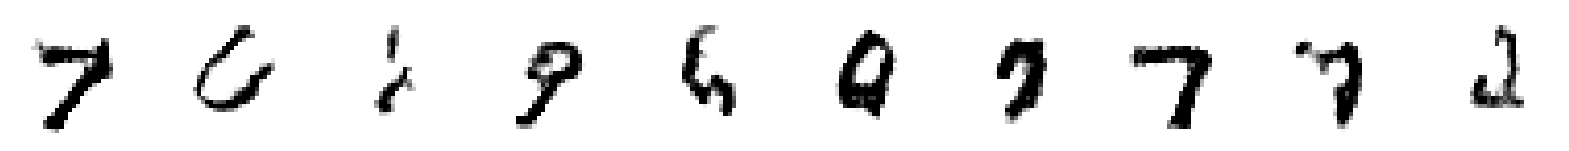


Saved to ./output/example_img_039.png


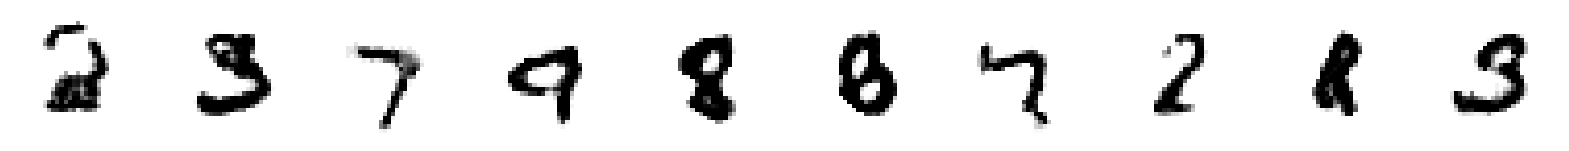

Epoch 40 Iteration Loop: 100%|██████████| 375/375 [03:36<00:00,  1.73it/s]


Epoch 40 train loss : -0.00031992319389246405

Saved to ./output/generated_img_040.png


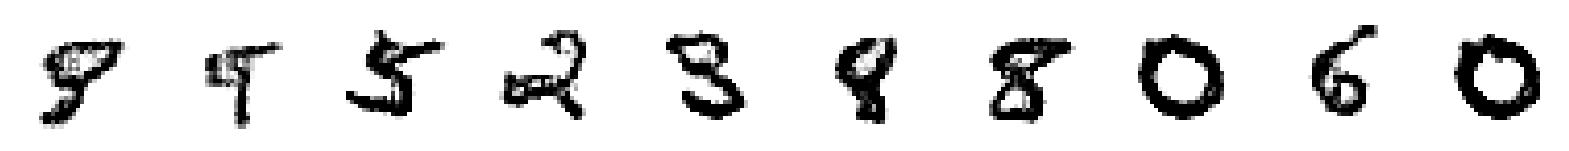


Saved to ./output/example_img_040.png


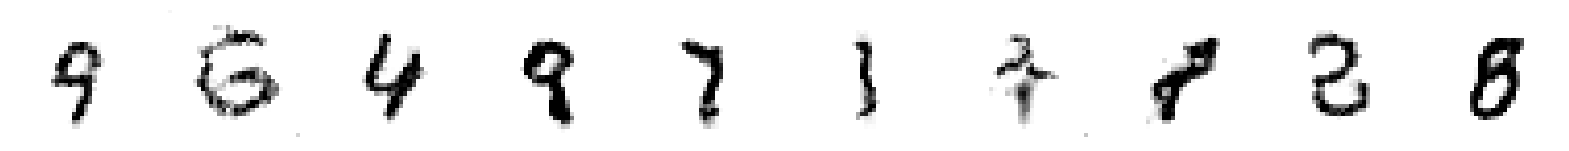

Epoch 41 Iteration Loop: 100%|██████████| 375/375 [03:41<00:00,  1.69it/s]


Epoch 41 train loss : -0.00031949873865232803

Saved to ./output/generated_img_041.png


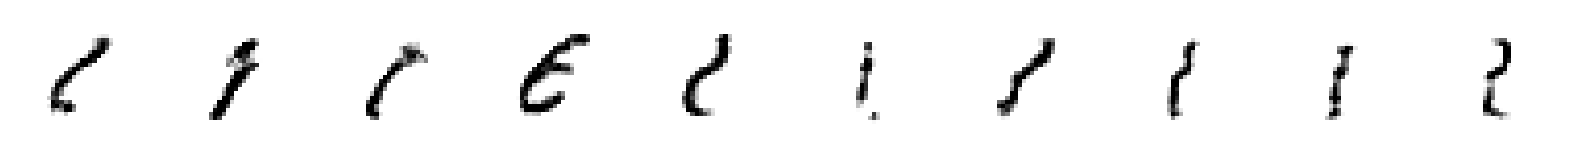


Saved to ./output/example_img_041.png


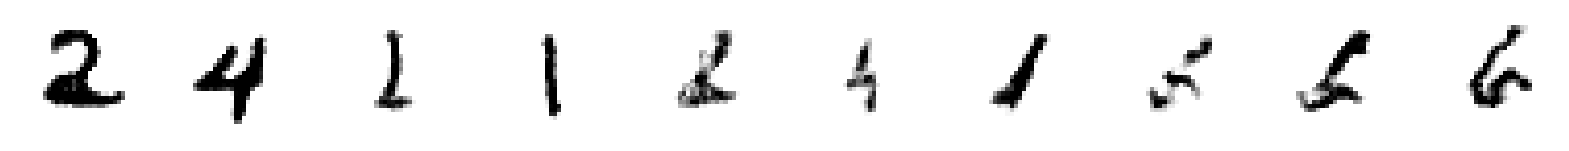

Epoch 42 Iteration Loop: 100%|██████████| 375/375 [03:29<00:00,  1.79it/s]


Epoch 42 train loss : -7.427789755941679e-06

Saved to ./output/generated_img_042.png


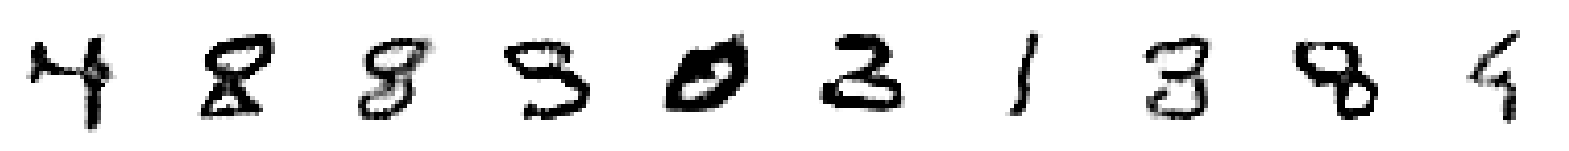


Saved to ./output/example_img_042.png


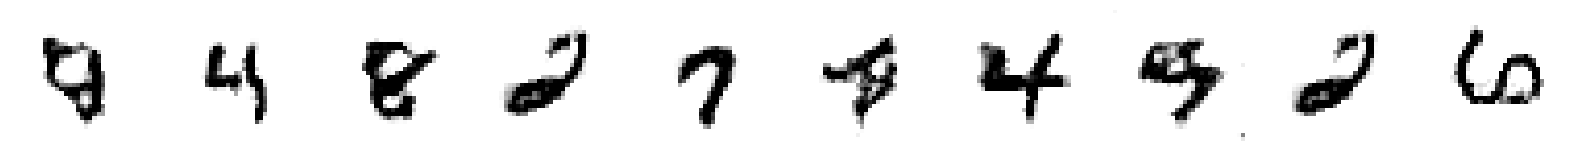

Epoch 43 Iteration Loop: 100%|██████████| 375/375 [03:43<00:00,  1.68it/s]


Epoch 43 train loss : -0.00045245432578182467

Saved to ./output/generated_img_043.png


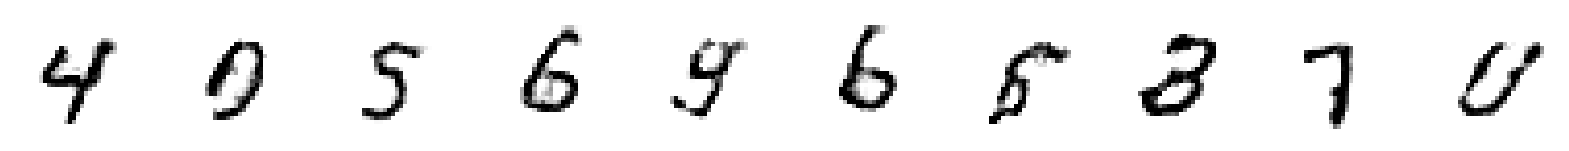


Saved to ./output/example_img_043.png


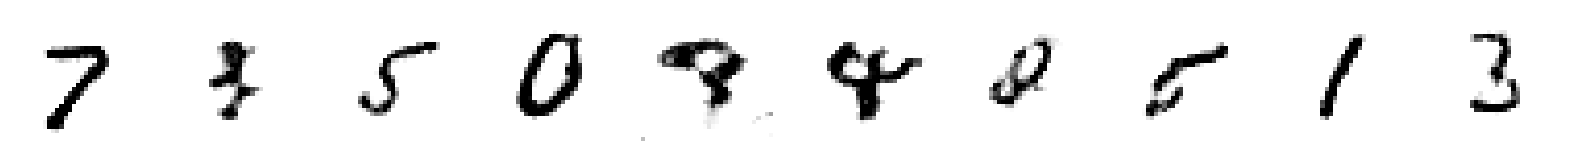

Epoch 44 Iteration Loop: 100%|██████████| 375/375 [03:52<00:00,  1.61it/s]


Epoch 44 train loss : -0.00019181488448521123

Saved to ./output/generated_img_044.png


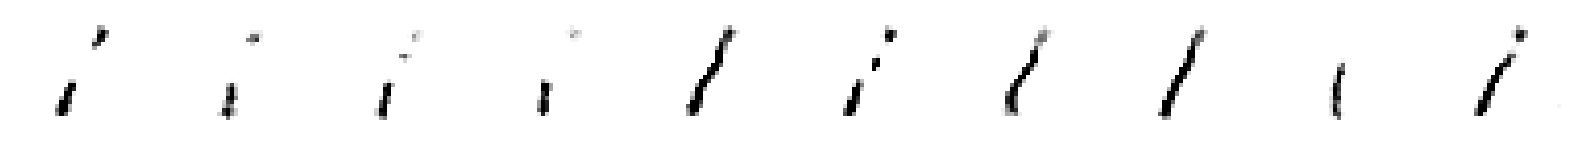


Saved to ./output/example_img_044.png


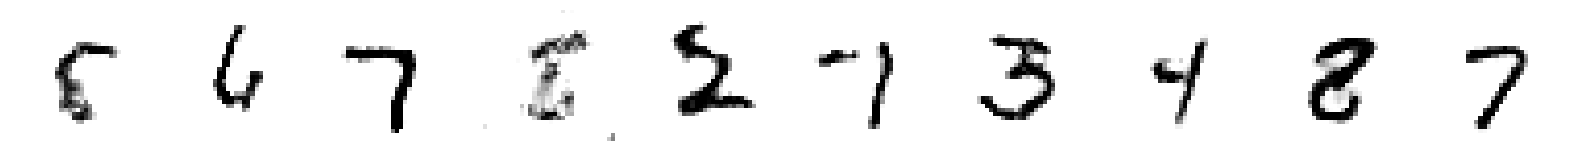

Epoch 45 Iteration Loop: 100%|██████████| 375/375 [04:09<00:00,  1.50it/s]


Epoch 45 train loss : -0.00027192925890752424

Saved to ./output/generated_img_045.png


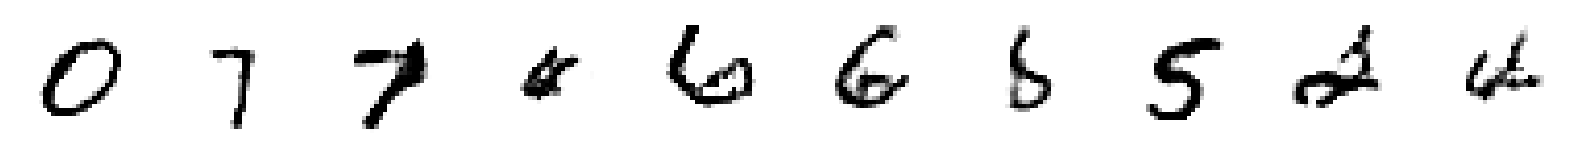


Saved to ./output/example_img_045.png


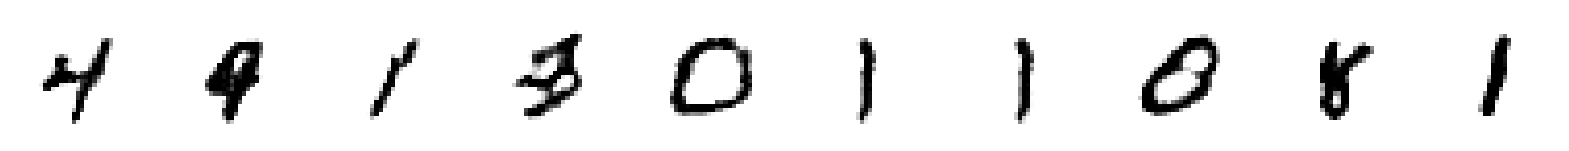

Epoch 46 Iteration Loop: 100%|██████████| 375/375 [06:24<00:00,  1.02s/it]


Epoch 46 train loss : -0.0003497214191787255

Saved to ./output/generated_img_046.png


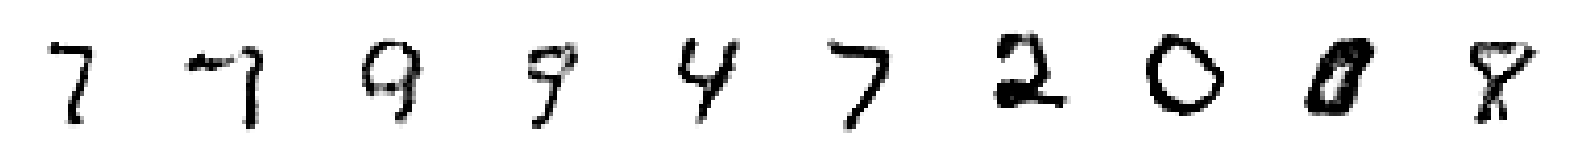


Saved to ./output/example_img_046.png


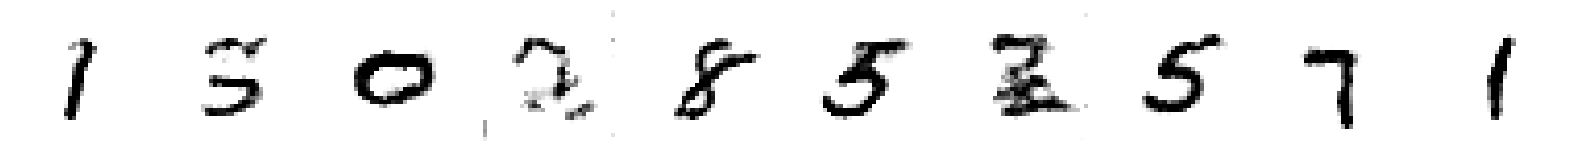

Epoch 47 Iteration Loop: 100%|██████████| 375/375 [06:37<00:00,  1.06s/it]


Epoch 47 train loss : -0.00014128479177209858

Saved to ./output/generated_img_047.png


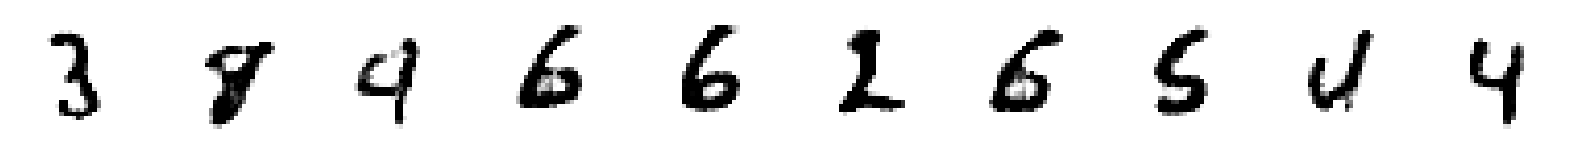


Saved to ./output/example_img_047.png


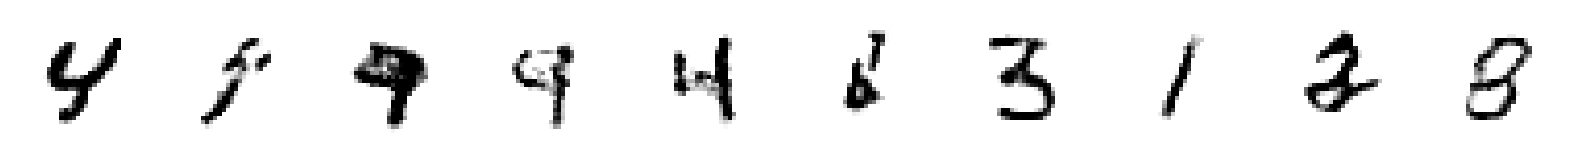

Epoch 48 Iteration Loop: 100%|██████████| 375/375 [05:48<00:00,  1.07it/s]


Epoch 48 train loss : -0.00022960831647894035

Saved to ./output/generated_img_048.png


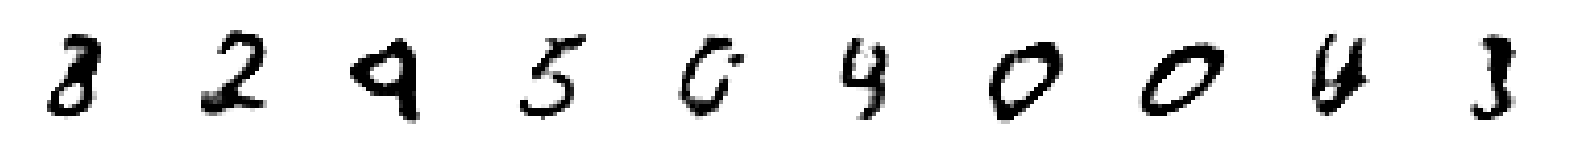


Saved to ./output/example_img_048.png


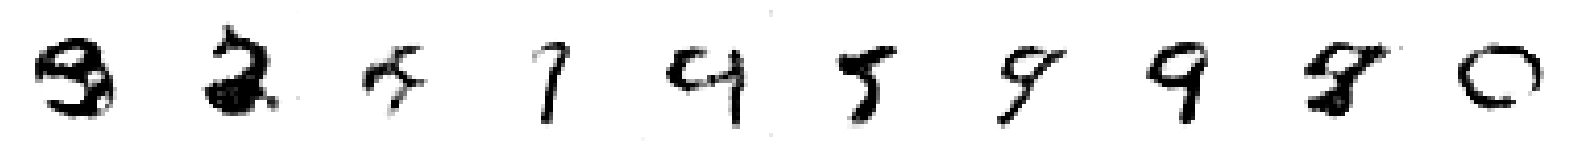

Epoch 49 Iteration Loop: 100%|██████████| 375/375 [06:37<00:00,  1.06s/it]


Epoch 49 train loss : -0.0003441227936030676

Saved to ./output/generated_img_049.png


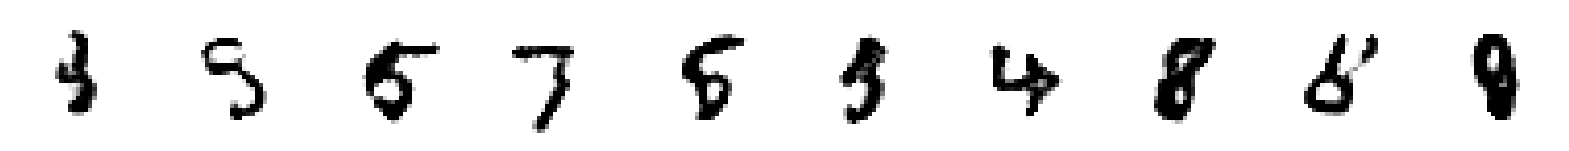


Saved to ./output/example_img_049.png


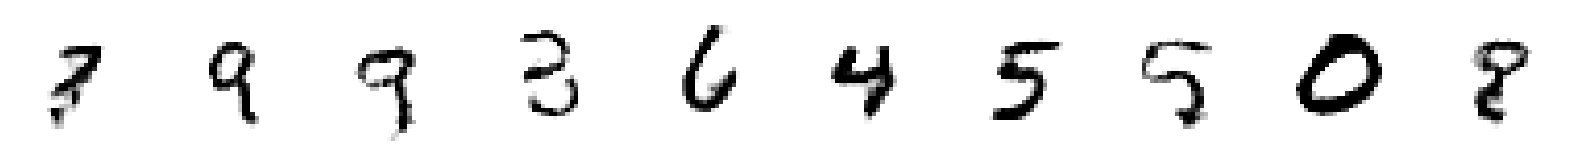

Epoch 50 Iteration Loop: 100%|██████████| 375/375 [06:49<00:00,  1.09s/it]


Epoch 50 train loss : -0.00038609449293774864

Saved to ./output/generated_img_050.png


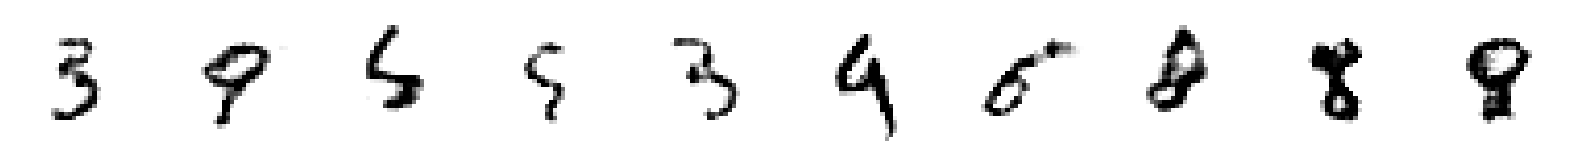


Saved to ./output/example_img_050.png


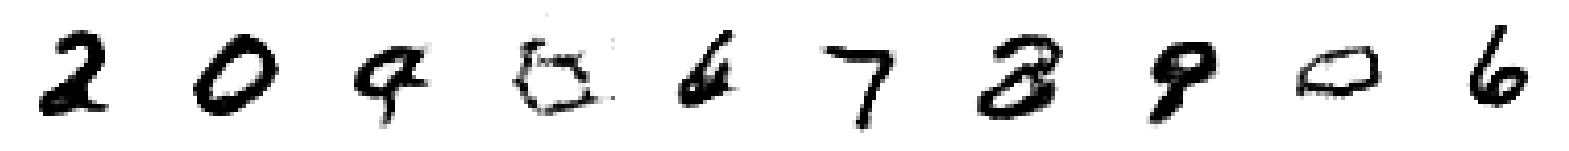

Epoch 51 Iteration Loop: 100%|██████████| 375/375 [06:04<00:00,  1.03it/s]


Epoch 51 train loss : -0.00038210158709747093

Saved to ./output/generated_img_051.png


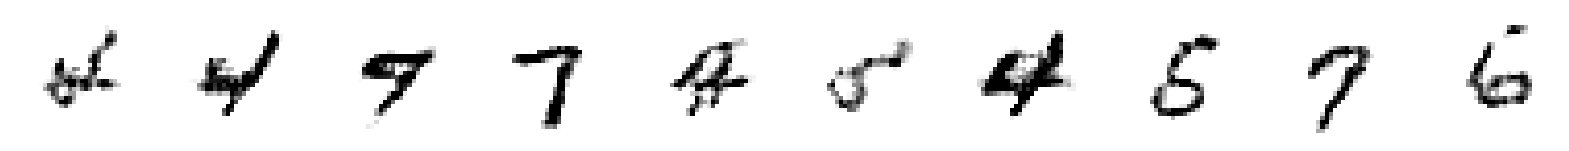


Saved to ./output/example_img_051.png


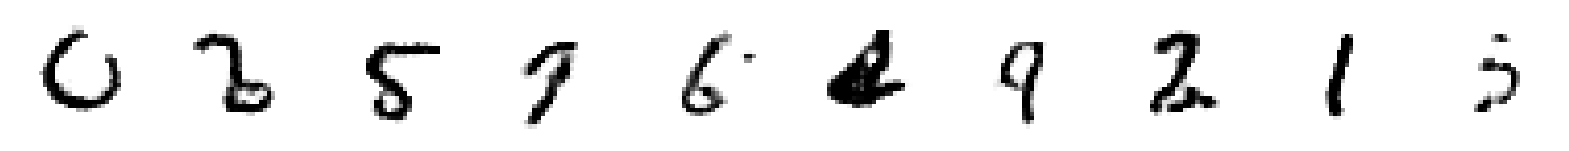

Epoch 52 Iteration Loop: 100%|██████████| 375/375 [06:40<00:00,  1.07s/it]


Epoch 52 train loss : -0.0002959692647564225

Saved to ./output/generated_img_052.png


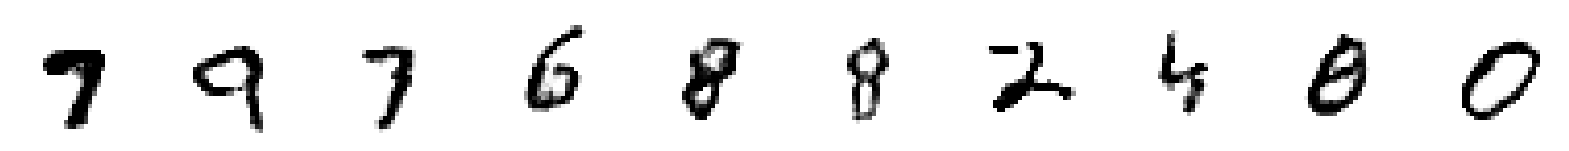


Saved to ./output/example_img_052.png


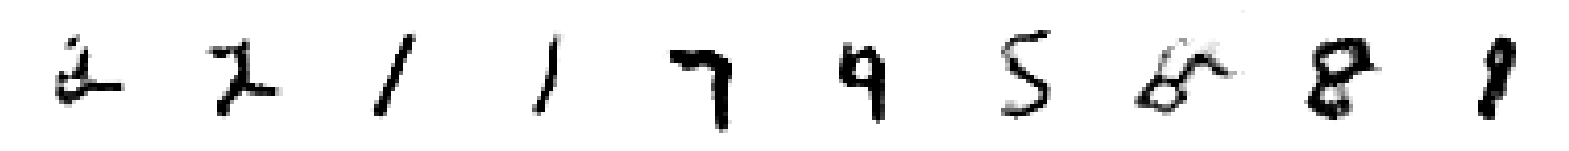

Epoch 53 Iteration Loop: 100%|██████████| 375/375 [06:50<00:00,  1.10s/it]


Epoch 53 train loss : -0.00010356420495857795

Saved to ./output/generated_img_053.png


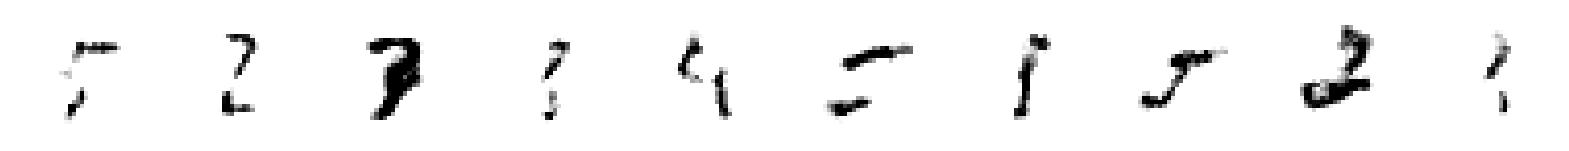


Saved to ./output/example_img_053.png


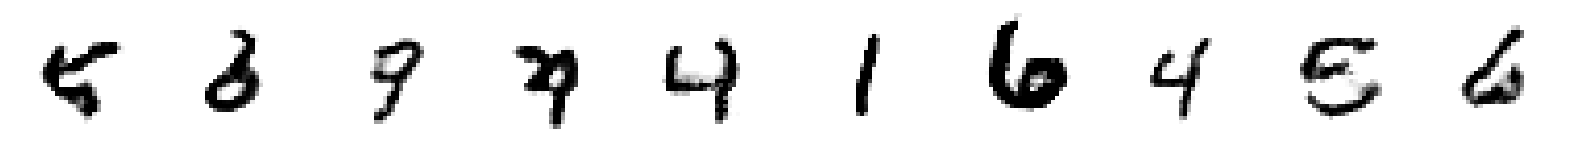

Epoch 54 Iteration Loop: 100%|██████████| 375/375 [06:48<00:00,  1.09s/it]


Epoch 54 train loss : -1.8008127071273823e-05

Saved to ./output/generated_img_054.png


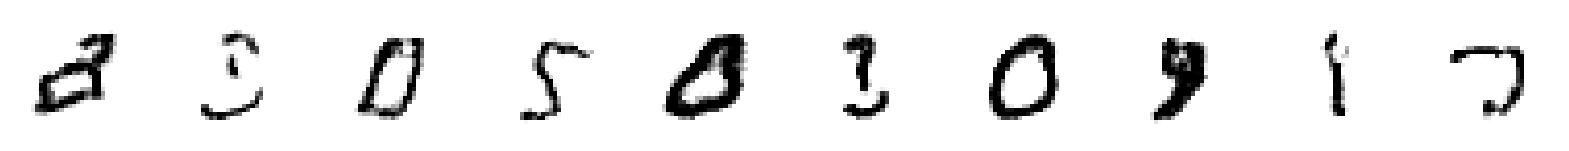


Saved to ./output/example_img_054.png


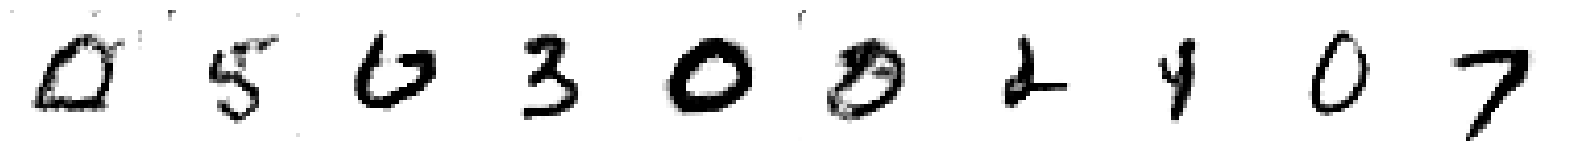

Epoch 55 Iteration Loop: 100%|██████████| 375/375 [05:49<00:00,  1.07it/s]


Epoch 55 train loss : -0.000407527078166216

Saved to ./output/generated_img_055.png


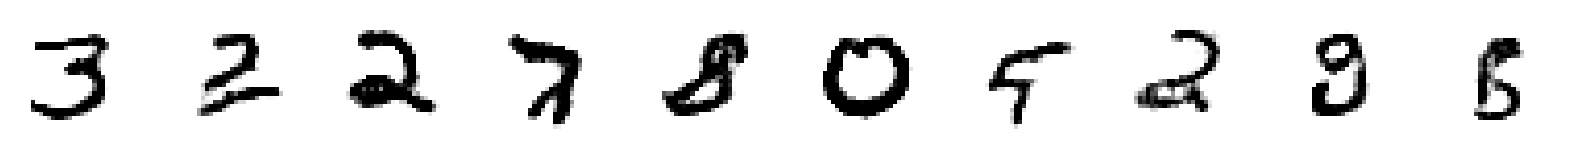


Saved to ./output/example_img_055.png


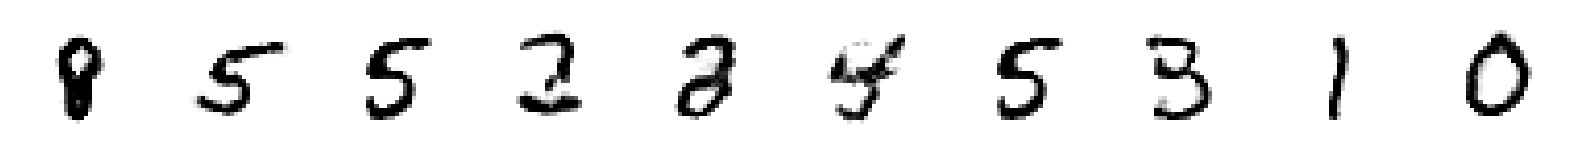

Epoch 56 Iteration Loop: 100%|██████████| 375/375 [06:49<00:00,  1.09s/it]


Epoch 56 train loss : -0.00032155630423221735

Saved to ./output/generated_img_056.png


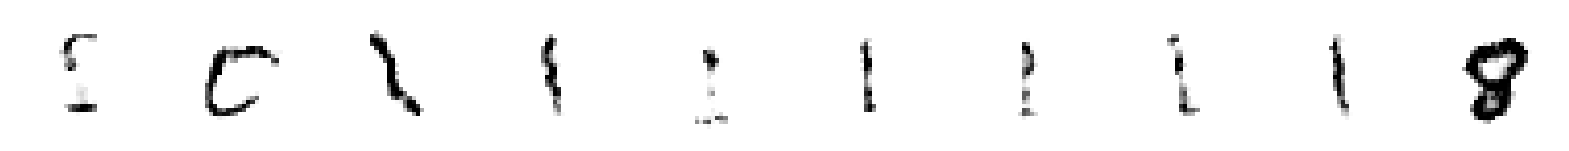


Saved to ./output/example_img_056.png


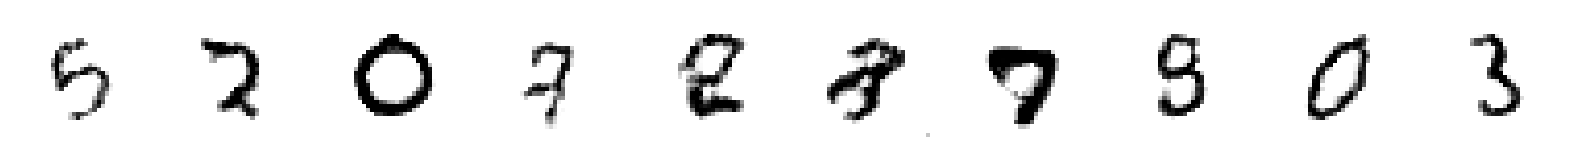

Epoch 57 Iteration Loop: 100%|██████████| 375/375 [06:51<00:00,  1.10s/it]


Epoch 57 train loss : -0.00018495395787370702

Saved to ./output/generated_img_057.png


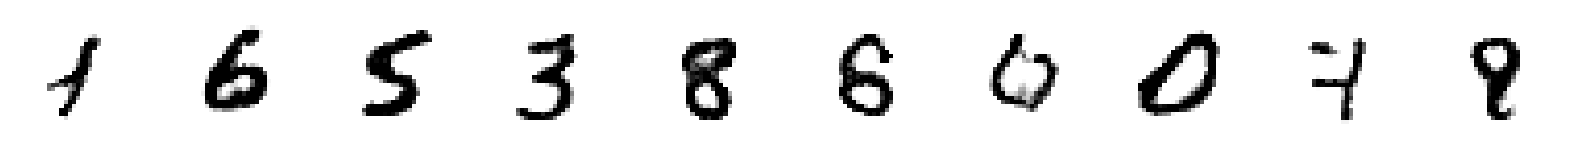


Saved to ./output/example_img_057.png


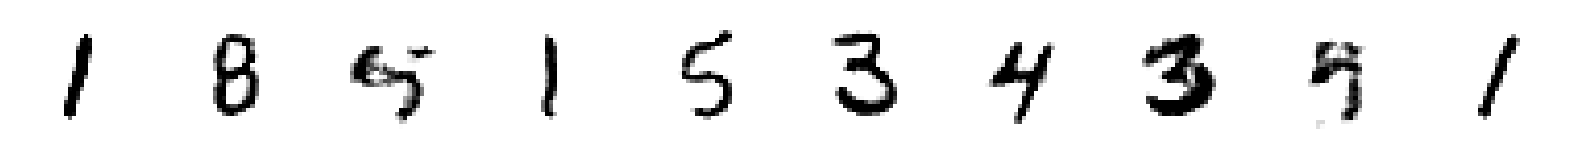

Epoch 58 Iteration Loop: 100%|██████████| 375/375 [06:34<00:00,  1.05s/it]


Epoch 58 train loss : -0.00037536754525111367

Saved to ./output/generated_img_058.png


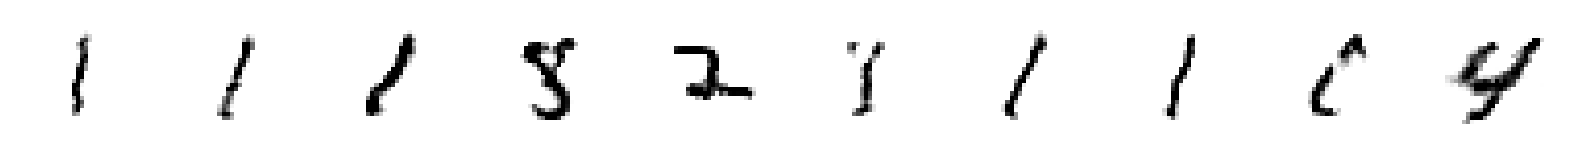


Saved to ./output/example_img_058.png


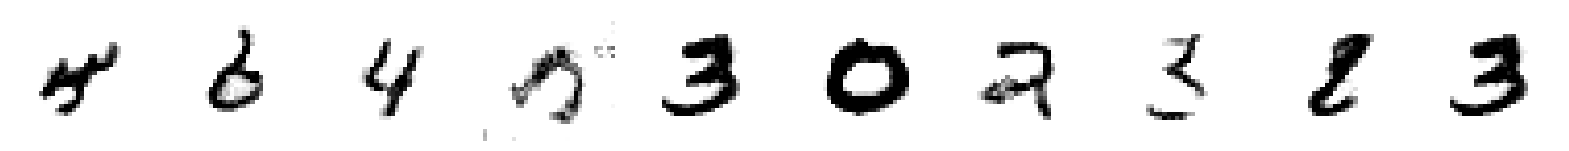

Epoch 59 Iteration Loop: 100%|██████████| 375/375 [06:25<00:00,  1.03s/it]


Epoch 59 train loss : -0.0003955233568364444

Saved to ./output/generated_img_059.png


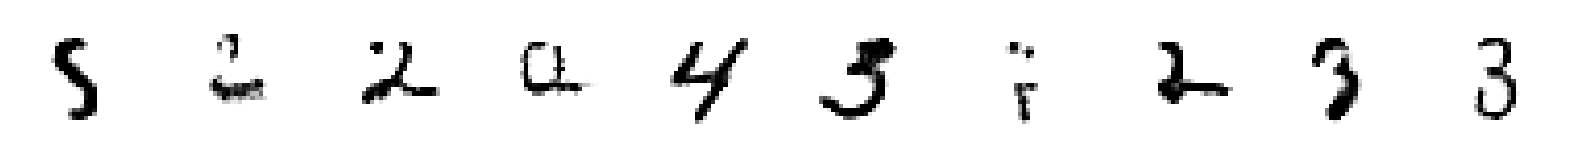


Saved to ./output/example_img_059.png


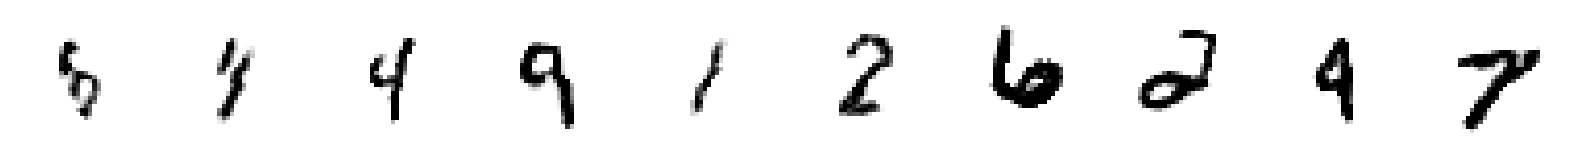

Epoch 60 Iteration Loop: 100%|██████████| 375/375 [06:55<00:00,  1.11s/it]


Epoch 60 train loss : -0.00031916449688530215

Saved to ./output/generated_img_060.png


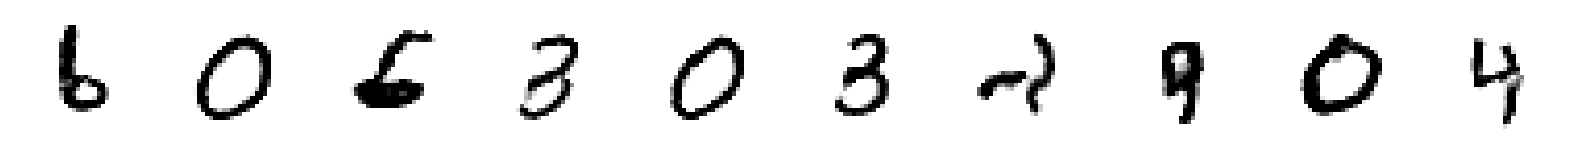


Saved to ./output/example_img_060.png


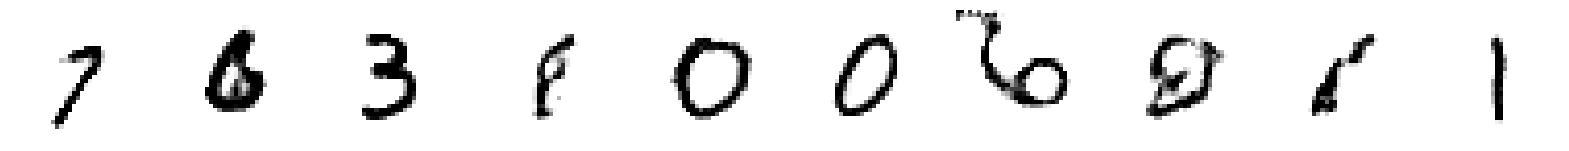

Epoch Loop: 100%|██████████| 60/60 [3:49:24<00:00, 229.41s/it]


In [23]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

train_losses, val_losses, cdiv_losses, reg_losses, real_outs, fake_outs = training_loop(EPOCHS,optimizer,model,buffer,loss_fn,train_loader,val_loader)

In [24]:
torch.save(model.state_dict(),str(models_folder/"ebm_last_epoch_pytorch_weights.pt"))